### Version 1: Clyfar
The main changes are:
* Add memory aspect, e.g., yesterday's ozone; days with cold pool
* Pseudo-lapse-rate 
* Arctinic (see Neimann paper)
* Soil temperature
* Rename or redo solar insolation?
* Hand-picked five stations per variable to create representative value?
  - Especially for COOP snow stations
* There needs to be a proxy in the NWP forecast data!



In [1]:
import os

import numpy as np
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import pandas as pd

from fis.fis import FIS
# from fis.v0p1 import ozone_ctrl
# from main import ozone_sim
from obs.obsdata import ObsData

/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/synoptic/accessors.py:28: UserWarning: map making not available without Brian's cartopy_tools
  warnings.warn("map making not available without Brian's cartopy_tools")


In [2]:
plt.rc('text', usetex=False)
plt.rc('font', family='Helvetica')

plt.rcParams['figure.dpi'] = 350

# pastel colour set for multiple lines on plot
mycolors = ['#FFA07A', '#20B2AA', '#778899', '#FF6347', '#4682B4', '#FFD700',
            '#8A2BE2', '#00FF7F', '#FF4500', '#00FFFF']

pc_colors = {
    # 10th percentile, low estimate of ozone, "green"
    10: '#00FF7F',
    # 50th percentile, middle estimate of ozone, "orange"
    50: '#FFA07A',
    # 90th percentile, high estimate of ozone, "red"
    90: '#FF6347',
}

ozone_cats = {
    "background": "#6CA0DC",
    "moderate": "#FFD700",
    "elevated": "#FF8C00",
    "extreme": "#FF6F61"
}

wind_cats = {
    "calm": "#6CA0DC",
    "breezy": "#FFD700"
}

snow_cats = {
    "negligible": "#6CA0DC",
    "sufficient": "#FFD700"
}

mslp_cats = {
    "low": "#6CA0DC",
    "moderate": "#FFD700",
    "high": "#FF6F61"
}

solar_cats = {
    "low": "#6CA0DC",
    "moderate": "#FFD700",
    "high": "#FF6F61"
}

# Define the maroon/purple color for the example lines
fave_color = '#4B0082'

In [3]:
year = 2024

snow_stids = ['COOPJENU1', 'COOPFTDU1', 'COOPALMU1', 'COOPDINU1', 'COOPROSU1',
              'COOPVELU1', 'COOPDSNU1', 'COOPOURU1', 'COOPNELU1']
wind_stids = ['DURU1', 'A1622', 'SPMU1', 'QV4', 'WAXU1', 'E8302', 'KVEL', 'QRS', 'MYT5']
solar_stids = ["DURU1", "A1622", "SPMU1", "WAXU1"]
ozone_stids = ["QV4", "QRS"]
mslp_stids = ["KVEL",]

In [4]:
# Snow in mm up to 250mm (0.82 ft; 9.84 in) and anything more is clipped to the max
snow_uod = np.arange(0, 251, 2)

# This is just valid for KVEL
mslp_uod = np.arange(995E2, 1050.1E2, 0.5E2)

# Wind has sigmoid. m/s
wind_uod = np.arange(0, 15.1, 0.25)

# Solar
solar_uod = np.arange(100, 1105, 5)

# Ozone - the output
ozone_uod = np.arange(20, 141, 1)

snow = ctrl.Antecedent(snow_uod, 'snow')
mslp = ctrl.Antecedent(mslp_uod, 'mslp')
wind = ctrl.Antecedent(wind_uod, 'wind')
solar = ctrl.Antecedent(solar_uod, 'solar')

ozone = ctrl.Consequent(ozone_uod, 'ozone', defuzzify_method='centroid')

In [5]:
# "sea_level_pressure" from KVEL will be the source. We take the median of daily values.

def do_repval_mslp(df, stids, vrbl_col="sea_level_pressure", stid_col="stid"):
    """Create representative values of mean sea level pressure from KVEL data.

    Notes:
        This is currently the variable "sea_level_pressure" from the station KVEL,
        ignoring "pressure" and "altimeter". Further, we note the index
        is in UTC and we need to shift to local time (US Mountain) considering
        the daylight savings change.

    Args:
        df (pd.DataFrame): The data frame with raw-ish data of
                        various stids and time frequencies and variables
        stids (list): The list of station IDs to consider for this calculation
        vrbl_col (str): The column name for the variable of interest
        stid_col (str): The column name for the station ID

    Returns:
        repr_df (pd.DataFrame): Time series of representative values of MSLP
                                    for the Basin
    """
    # Subset to just the stids and the two columns for the variable and station ID
    # (Those keys are set in the function signature)
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # We need to convert the index to local time
    df.index = df.index.tz_convert("US/Mountain")

    # We first reduce the dataset to daily values for each station computed
    # as the median of that station's values for that day.
    repr_df = df.groupby(stid_col).resample('D').median()

    # We then take the median over all stations for each day to create the representative value
    repr_df = repr_df.groupby(level=1).median()

    return repr_df


In [6]:
def do_repval_wind(df, stids, vrbl_col="wind_speed", stid_col="stid"):
    """Create representative values of wind speed from a subset of Uinta Basin stations.

    Args:
        df (pd.DataFrame): The data frame with the wind speed data where columns are the stations

    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")

    # First get 75th percentile of each station midnight to midnight local time
    daily_75th = df.groupby(stid_col).resample("D").quantile(0.75)

    # Then the 95th percentile of those values
    result = daily_75th.groupby(level=1).quantile(0.75)

    return result

In [7]:
def do_repval_snow(df, stids, vrbl_col="snow_depth", stid_col="stid"):
    """Create representative values of snow from the Uinta Basin stations.

    Notes:
        We use the stations "COOP*" in the Basin.

    Args:
        df (pd.DataFrame): The data frame with the snow data for all COOP stations

    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")

    # Compute 95th percentile of snow depth for each station's reports midnight to midnight local time
    daily_95th = df.groupby(stid_col).resample("D").quantile(0.95)

    # Then the 95th percentile of those values
    result = daily_95th.groupby(level=1).quantile(0.95)

    return result

In [8]:
def compute_nearzenithmean(df, solar_stids, vrbl_col="solar_radiation", stid_col="stid"):
    # Create a dictionary to store this "near-zenith mean" (nzm) for each station
    daily_solar_nzm = dict()

    for stid in solar_stids:
        # Get the time series for this station, only for the variable column
        sub_df = df.loc[df[stid_col] == stid, vrbl_col].dropna()  # Added .dropna()

        # For each station, compute mean from obs within each local day for the variable column
        daily_solar_nzm[stid] = sub_df.between_time("10:00", "14:00").resample("D").mean()

    # Create dataframe
    df_daily_solar_nzm = pd.concat(daily_solar_nzm, axis=0, ignore_index=False)
    df_daily_solar_nzm = do_nzm_filtering(df_daily_solar_nzm, solar_stids)
    return df_daily_solar_nzm

def do_nzm_filtering(df, solar_stids):
    """Filter the near-zenith mean insolation data by adding a rolling mean.

    Note:
        The first six days will be NaN due to the window. Start a week early.
        TODO: add a week for the operational model before starting Clyfar

    Args:
        df (pd.DataFrame): The data frame with the near-zenith mean insolation data
        solar_stids (list): The list of station IDs for solar radiation
    """
    all_filtered = {}
    for stid in solar_stids:
        sub_df = df.loc[stid].dropna()
        filtered_sub_df = sub_df.rolling(window=7).mean()
        all_filtered[stid] = filtered_sub_df
    filtered_df = pd.concat(all_filtered, axis=0, ignore_index=False)
    return filtered_df

def do_repval_solar(df, stids, vrbl_col="solar_radiation", stid_col="stid"):
    """Create representative values of insolation using "near-zenith mean" from four stations.

    Args:
        df (pd.DataFrame): The data frame with the insolation data where columns are the stations

    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")

    # Compute near-zenith mean for each station midnight to midnight local time
    df_daily_solar_nzm = compute_nearzenithmean(df, solar_stids)

    # 95th percentile
    result = df_daily_solar_nzm.groupby(level=1).quantile(0.95)

    return result

In [9]:
def do_repval_ozone(df, stids, vrbl_col="ozone_concentration", stid_col="stid"):
    """Create representative values of ozone concentration from multiple reliable stations.

    Args:
        df (pd.DataFrame): The data frame with the ozone data where columns are station IDs
            (stid), and ozone_concentration, and the index is a timestamp.
    """
    # Subset to just the stids and the two columns for the variable and station ID
    df = df[df[stid_col].isin(stids)][[vrbl_col, stid_col]]

    # Remove extreme values
    df.loc[df[vrbl_col] > 140, vrbl_col] = np.nan
    df.loc[df[vrbl_col] < 5, vrbl_col] = np.nan

    # Convert to local time zone from UTC (US/Mountain)
    df.index = df.index.tz_convert("US/Mountain")

    # First get the 99th percentile for each station, resampled daily (midnight to midnight)
    daily_99th = df.groupby(stid_col).resample('D').quantile(0.99)

    # For each day, take the 99th percentile of the daily 99th percentiles across stations for a single value per day
    result = daily_99th.groupby(level=1).quantile(0.99)

    return result


### Membership functions
We will define these with a special quintuple function inspired by Dubois & Prade (1988) book on possibility theory, hereby DP88. We use these over the `skfuzz` package for more control and explicit implementation of the DP88 book.

In [10]:
def trapmf_from_quintuple(x_uod: np.ndarray, x_left: float, m_lower: float,
                            m_upper: float, x_right: float,
                            h: float = 1.0) -> np.ndarray:

    """Create trapezium from five arguments that describe the shape.

    This version uses explicit x-coordinates instead of slopes, making it more
    intuitive to specify the shape. The parameters define:
    - The support (total range) of the function: [x_left, x_right]
    - The core (plateau) of the function: [m_lower, m_upper]
    - The height of the plateau: h

    Notes:
        Modified from Lawson 2024 pre-print for easier use. Instead of slopes,
        we directly specify the x-coordinates where membership starts and ends.
        The core [m_lower, m_upper] defines where membership reaches its maximum h,
        while [x_left, x_right] defines the total range of non-zero membership.

    We assert that y=0 at the left and right extremes as we do not consider variables where all x
    are constantly possible for a given category.

    Args:
        x_uod (np.ndarray): Universe of discourse for the x-axis
        x_left (float): Leftmost point where membership becomes non-zero
        m_lower (float): Lower boundary of trapezoid plateau (core start)
        m_upper (float): Upper boundary of trapezoid plateau (core end)
        x_right (float): Rightmost point where membership becomes zero
        h (float, optional): Height of trapezoid. Defaults to 1.0

    Returns:
        np.ndarray: Array same shape as x_uod containing membership values
    """
    # Input validation
    assert x_left < m_lower <= m_upper < x_right, ("Must satisfy:"
                    "x_left < m_lower <= m_upper < x_right")
    assert 0 <= h <= 1, "h must be in [0, 1]"

    # Create result array
    result = np.zeros_like(x_uod, dtype=float)

    # Left slope region
    mask_left = (x_left <= x_uod) & (x_uod < m_lower)
    slope_left = h / (m_lower - x_left)  # Calculate slope from points
    result[mask_left] = slope_left * (x_uod[mask_left] - x_left)

    # Plateau region
    mask_plateau = (m_lower <= x_uod) & (x_uod <= m_upper)
    result[mask_plateau] = h

    # Right slope region
    mask_right = (m_upper < x_uod) & (x_uod <= x_right)
    slope_right = -h / (x_right - m_upper)  # Calculate slope from points
    result[mask_right] = h + slope_right * (x_uod[mask_right] - m_upper)

    # All other regions remain 0 by initialization
    return result

def plsmf_from_quadruple(x_uod: np.ndarray, h_left: float, x_left: float,
                         x_right: float, h_right: float,
                         ) -> np.ndarray:
    """Create a piecewise linear signoid-like shape from four arguments.

    Usually both h_left and h_right are in {0, 1} as a transition from one
    state (e.g., True) to another (False). We could also assume that h_left
    and h_right are 0 or 1 and set whether rising slope is True or False, but
    that loses potential future functionality to have non-binary ends.

    Args:
        x_uod (np.array): Universe of discourse for the x-axis.
        h_left (float): Height at left inflection point.
        x_left (float): x-value at left inflection point.
        x_right (float): x-value at right inflection point.
        h_right (float): Height at right inflection point.

    Returns:
        np.ndarray: Array same shape as x_uod containing membership values.
    """
    assert x_left < x_right, "x_left must be less than x_right"
    assert 0 <= h_left <= 1, "h_left must be in [0, 1]"
    assert 0 <= h_right <= 1, "h_right must be in [0, 1]"
    # JRL: I don't think the below is needed because skfuzz does interpolation.
    # assert x_left in x_uod, "x_left must be in x_uod"
    # assert x_right in x_uod, "x_right must be in x_uod"

    # Create the piecewise linear function numpy array same size as x_uod
    result = np.zeros_like(x_uod, dtype=float)

    # Masking better for performance and clear "zones"

    # Left constant region
    mask_left = x_uod <= x_left
    result[mask_left] = h_left

    # Middle sloped region, here linear
    mask_middle = (x_left < x_uod) & (x_uod < x_right)
    slope = (h_right - h_left) / (x_right - x_left)
    result[mask_middle] = h_left + slope * (x_uod[mask_middle] - x_left)

    # Right constant region
    mask_right = x_right <= x_uod
    result[mask_right] = h_right

    return result

In [11]:
def plot_mf(ax, x, y, label=None, line_color="#4B0082", plot_fill=False, linestyle='-'):
    """Plot a membership function on a given axis.

    Args:
        ax (matplotlib.axes.Axes): The axis to plot the membership function on.
        x (np.ndarray): The universe of discourse (x-axis).
        y (np.ndarray): The membership function values (y-axis).
        label (str): The label for the membership function.
        line_color (str): The color of the line.
        plot_fill (bool): Whether to fill under the curve.
        linestyle (str): The line style to use (see matplotlib)

    Returns:
        ax (matplotlib.axes.Axes): The axis with the membership function plotted.

    """
    style_axes(ax)

    # Ensure y is at least 1-dimensional
    y = np.atleast_1d(y)

    # Check if there's only one non-zero value in y
    # TODO - if any vertical lines (right-angle triangle) this should also have a delta function
    if np.count_nonzero(y) == 1:
        idx = np.atleast_1d(np.nonzero(y))[0]
        ax.axvline(x=x[idx], color=line_color, linestyle='--', alpha=0.6)
        ax.set_xlim(x[0], x[-1])
        # Add a large circle at the value of y to show the limit
        # Plot over the axes lines so it is clear
        ax.plot(x[idx], y[idx], 'o', color=line_color, markersize=10,
                zorder=10, label='Singleton', linestyle=linestyle)
    else:
        ax.plot(x, y, color=line_color, linewidth=2, label=label, linestyle=linestyle)
        if plot_fill:
            # Fill under the curve with a hatched line_color
            ax.fill_between(x, 0, y, alpha=0.3, color=line_color, hatch='//')
    ax.set_ylim(-0.01,1.01)
    ax.legend()
    return ax

def style_axes(ax):
    """Apply common styling to the axes."""
    ax.spines['top'].set_color('#D3D3D3')  # light grey
    ax.spines['right'].set_color('#D3D3D3')  # light grey
    ax.spines['bottom'].set_linewidth(0.8)  # thinner axis lines
    ax.spines['left'].set_linewidth(0.8)

    # Make axes ticks use Helvetica font
    for tick in ax.get_xticklabels():
        tick.set_fontname("Helvetica")

    for tick in ax.get_yticklabels():
        tick.set_fontname("Helvetica")

    return ax

In [12]:
def defuzzify_percentiles(x_uod, y_agg, percentiles=None,
                          do_plot=False, plot_fill=False, save_path=None,
                          print_percentiles=False):
    """Defuzzify the aggregated membership function to specific percentiles.

    TODO: there's maybe a simpler way to do area under curve for piecewise linear..?
    """
    if percentiles is None:
        percentiles = [10, 50, 90]
    total_area = np.trapezoid(y_agg, x_uod)
    cumulative_area = np.cumsum((y_agg[:-1] + y_agg[1:]) / 2 * np.diff(x_uod))
    cumulative_area_normalized = cumulative_area / total_area

    percentile_results = {}
    for p in percentiles:
        idx = np.where(cumulative_area_normalized >= p / 100.0)[0]
        if idx.size > 0:
            percentile_results[p] = x_uod[idx[0]]
            # percentile_results[f'{p}th percentile'] = x_uod[idx[0]]
        else:
            # percentile_results[f'{p}th percentile'] = x_uod[-1]
            percentile_results[p] = x_uod[-1]

    if do_plot:
        fig, ax = plt.subplots(1, figsize=(8, 6))
        ax.plot(x_uod, y_agg, color='#4B0082', linewidth=2)
        for p in percentiles:
            ax.axvline(x=percentile_results[p], color='grey', linestyle='--', alpha=0.6)
        ax.set_title('Defuzzified Percentiles', fontsize=14)
        ax.set_xlabel('Ozone (ppb)', fontsize=12)
        ax.set_ylabel('Degree of membership μ', fontsize=12)
        ax.set_ylim(-0.02, 1.02)
        ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
        ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
        ax.grid(False)
        style_axes(ax)

        if plot_fill:
            ax.fill_between(x_uod, 0, y_agg, alpha=0.4, facecolor='#4B0082', hatch='//')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

    if print_percentiles:
        print("Percentiles:")
        for k, v in percentile_results.items():
            print(f"  {k}th: {v:.2f} ppb")

    return percentile_results


In [13]:
def compute_aggregated_distr(poss_df, ozone):
    y_list = []
    for ozone_cat in ozone.terms.keys():
        activation = poss_df['possibility'][ozone_cat]
        clipped_mf = clip_distr(ozone[ozone_cat].mf, activation)
        y_list.append(clipped_mf)

    y_agg = np.maximum.reduce(y_list)
    return y_agg

In [14]:
def check_possibility_curve(poss_df, ozone):
    y_agg = compute_aggregated_distr(poss_df, ozone)

    pc_dict = defuzzify_percentiles(
        ozone.universe,
        y_agg,
        percentiles=[10, 50, 90],
        do_plot=True,
        plot_fill=True,
        print_percentiles=True,
    )
    return pc_dict

In [15]:

def make_mf_figure(x_uod, mf_arrays, plot_union=False, plot_intersection=False,
                   plot_colors=None, return_aggregated=False, save_path="mf_figure.pdf"):
    """Create a figure for multiple membership functions.

    Args:
        x_uod (np.ndarray): Universe of discourse for the x-axis.
        mf_arrays (dict): Dictionary of {shape: membership function}.
        plot_union (bool): Whether to plot the union of the membership functions.
        plot_intersection (bool): Whether to plot the intersection of the membership functions.
        plot_colors (dict): Dictionary of {shape: color} for the line colors.
        return_aggregated (bool): Whether to return the aggregated membership function.
        save_path (str): Path to save the figure to.

    Returns:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes.Axes): The axis object.
        y_union (np.ndarray): The aggregated membership function if requested.

    """
    fig, ax = plt.subplots(1)
    ax = style_axes(ax)
    ys = []

    for shape, y_ in mf_arrays.items():
        print(shape)
        lc = plot_colors.get(shape, '#4B0082') if plot_colors else '#4B0082'
        plot_mf(ax, x_uod, y_, label=shape, line_color=lc)
        ys.append(y_)

    if plot_union:
        y_union = np.maximum.reduce(ys)
        plot_mf(ax, x_uod, y_union, label="Union", line_color="black", linestyle='--')
        ax.fill_between(x_uod, 0, y_union, facecolor="grey", alpha=0.3, hatch='//')

        if return_aggregated:
            # plt.savefig(save_path, bbox_inches='tight')
            # plt.close()
            return fig, ax, y_union

    if plot_intersection:
        y_intersection = np.minimum.reduce(ys)
        plot_mf(ax, x_uod, y_intersection, label="Intersection", line_color="black", linestyle='--')
        ax.fill_between(x_uod, 0, y_intersection, facecolor="grey", alpha=0.3, hatch='//')
        if return_aggregated:
            # plt.savefig(save_path, bbox_inches='tight')
            # plt.close()
            return fig, ax, y_intersection

    plt.tight_layout()
    # plt.savefig(save_path, bbox_inches='tight')
    # plt.close()
    if return_aggregated:
        return fig, ax, None
    return fig, ax

In [16]:
def plot_all_categories(ax, variable, line_colors=None, plot_fill=True):
    """Plot all categories of a given variable on a given axis.

    Args:
        ax (matplotlib.axes.Axes): The axis to plot the membership functions on.
        variable (skfuzzy.control.Antecedent or skfuzzy.control.Consequent): The variable with categories to plot.
        line_colors (dict, optional): Dictionary for line colors in format {label: color}. Defaults to None.
        plot_fill (bool, optional): Whether to fill under the curves. Defaults to False.

    Returns:
        ax (matplotlib.axes.Axes): The axis with the membership functions plotted.
    """
    # if line_colors is None:
    #     line_colors = [None] * len(variable.terms)

    for label, term in variable.terms.items():
        print(label, term)
        color = line_colors[label] if line_colors is not None else None
        ax = plot_mf(ax, variable.universe, term.mf, label=label, line_color=color, plot_fill=plot_fill)

        # Special markers for ozone levels
        if label == "ozone":
            ax.axvline(x=40, color=fave_color, linestyle='--', alpha=0.6)
            ax.axvline(x=70, color=fave_color, linestyle='--', alpha=0.6)

    return ax


In [17]:
def create_possibility_array(sim, fis_ctrl, normalize=False):
    possibility_array = np.array([k.membership_value[sim] for k in fis_ctrl.terms.values()])
    if normalize:
        print("Normalizing")
        possibility_array = do_normalization(possibility_array)
    return possibility_array

def do_normalization(possibility_array):
    # Rescale the possibility array to ensure sup(possibility) = 1
    # Not sure what axis!
    possibility_array_norm = possibility_array / np.max(possibility_array)
    return possibility_array_norm

In [18]:
def create_possibility_df(sim, consequent, category_names, normalize=False):
    possibility_array = create_possibility_array(sim, consequent, normalize=normalize)
    df = pd.DataFrame(index=category_names)
    df['possibility'] = possibility_array
    return df

### Defining categories and membership functions

### Looking at data to decide on membership functions
First, one issue is MSLP has weird values and we need to look at distributions for the "representative value" we derived for the Basin.

In [19]:
# Crossover around 85mm for snow
snow['negligible'] = plsmf_from_quadruple(snow_uod, 1, 60, 90, 0)
snow['sufficient'] = plsmf_from_quadruple(snow_uod, 0, 60, 90, 1)


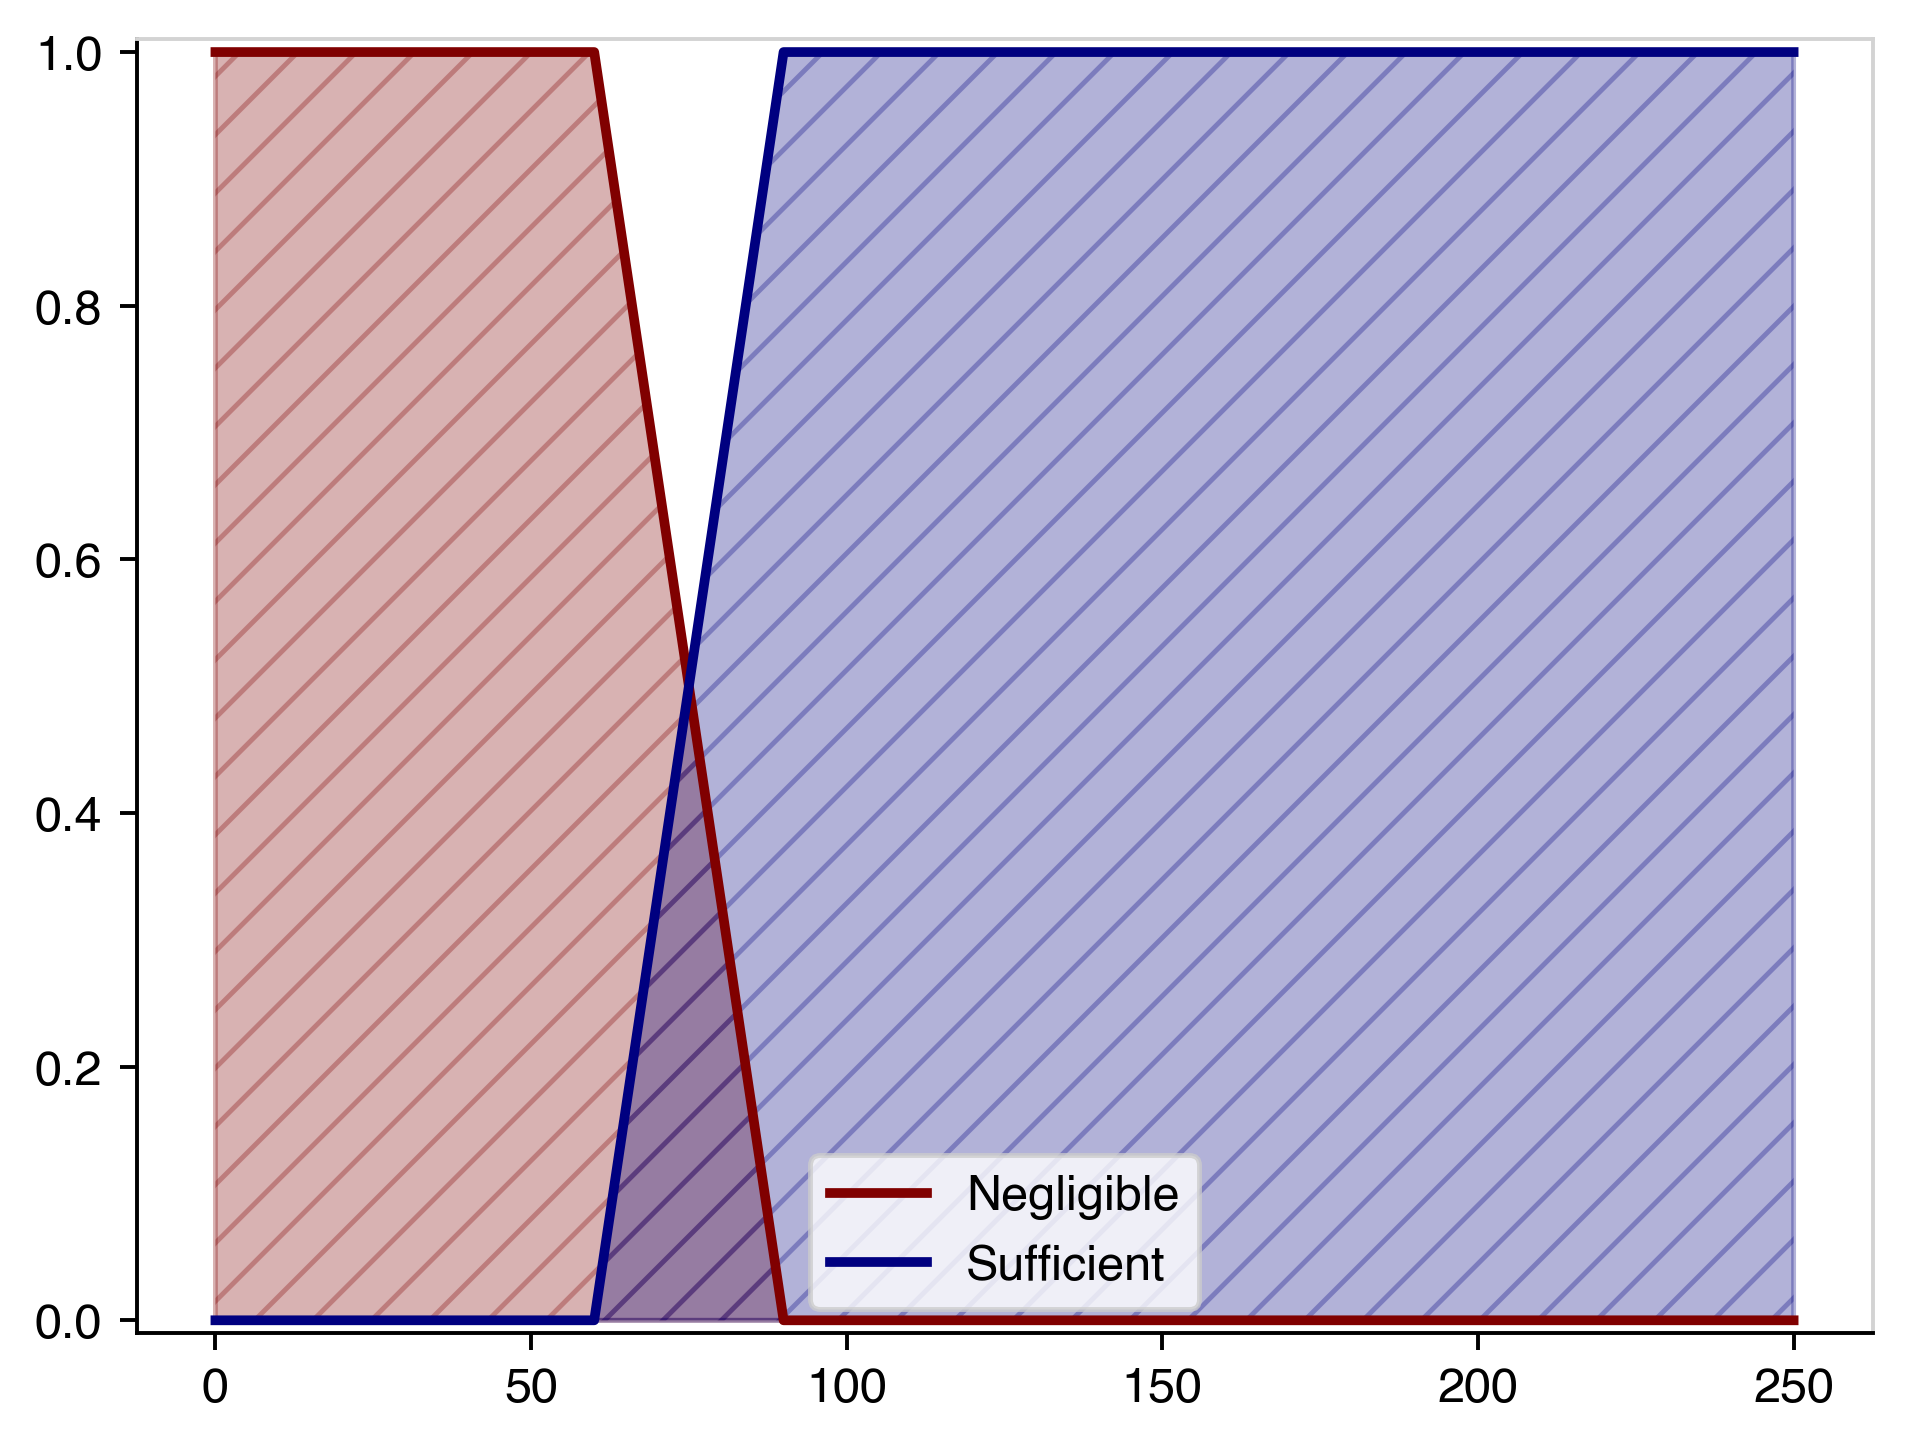

In [20]:
# Plot these functions
fig, ax = plt.subplots(1)
ax = plot_mf(ax, snow.universe, snow['negligible'].mf, label="Negligible", line_color="maroon", plot_fill=True)
ax = plot_mf(ax, snow.universe, snow['sufficient'].mf, label="Sufficient", line_color="navy", plot_fill=True)
plt.show()

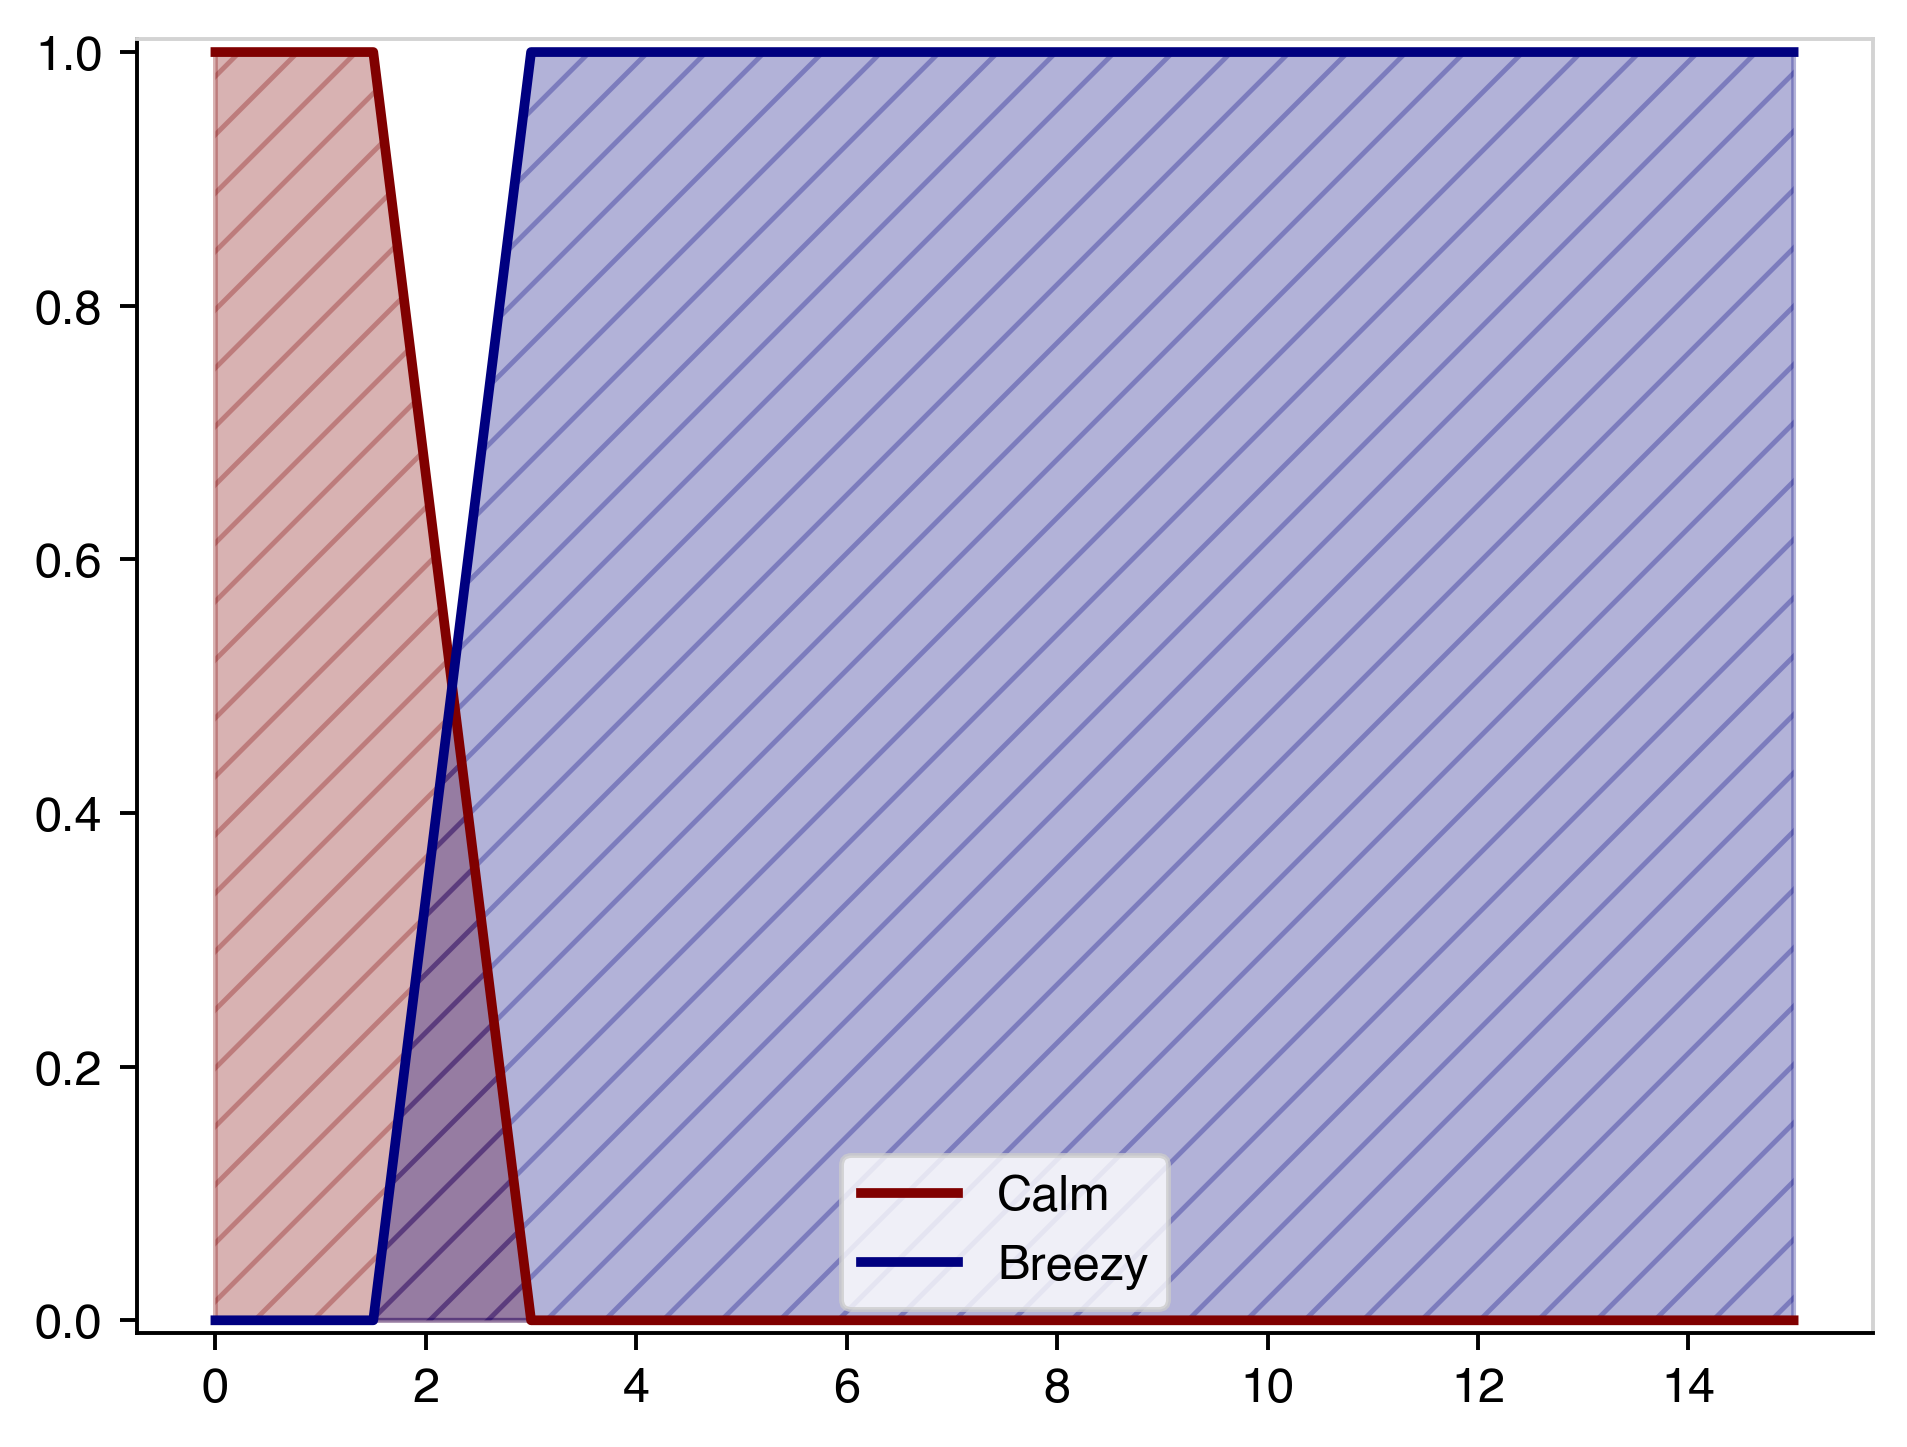

In [21]:
# Crossover around 2m/s for wind
wind['calm'] = plsmf_from_quadruple(wind_uod, 1, 1.5, 3.0, 0)
wind['breezy'] = plsmf_from_quadruple(wind_uod, 0, 1.5, 3.0, 1)

# Plot these functions
fig, ax = plt.subplots(1)
ax = plot_mf(ax, wind.universe, wind['calm'].mf, label="Calm", line_color="maroon", plot_fill=True)
ax = plot_mf(ax, wind.universe, wind['breezy'].mf, label="Breezy", line_color="navy", plot_fill=True)
plt.show()


low mslp[low]
moderate mslp[moderate]
high mslp[high]


<Axes: >

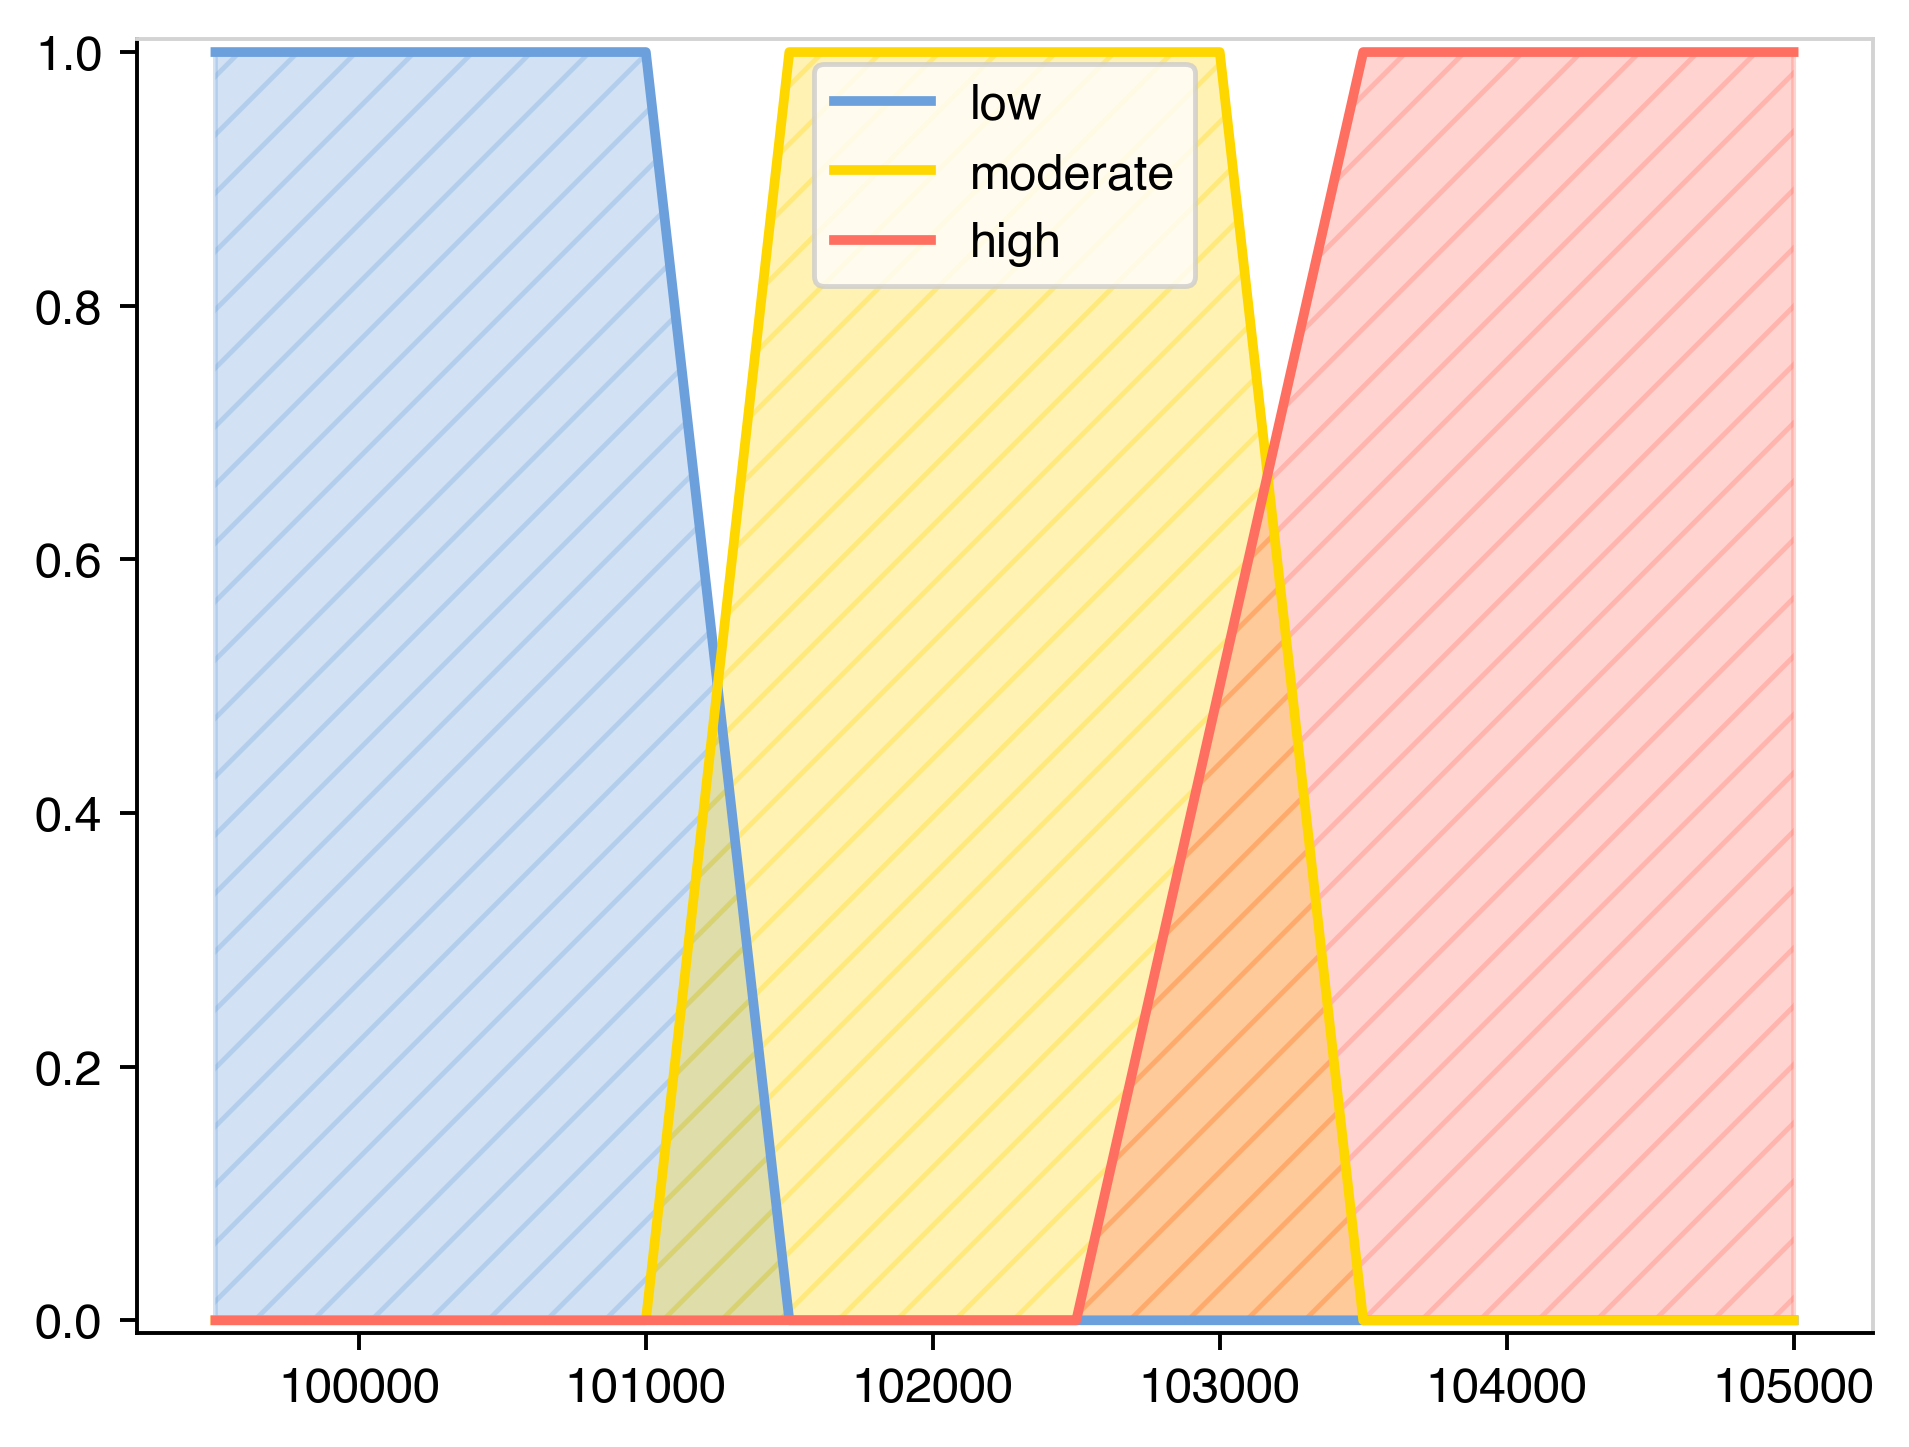

In [22]:
# Three trapezia for MSLP: low, medium, high

# Low and high will be piecewise linear sigmoid-like functions.
# Medium will be a trapezium.

# Determining range and core of trapezia:

# Low: left (1), transitioning between 1010 and 1020 to right (0)

# Med support: 1010 to 1035
# Med core: 1020 to 1030

# High support: left (0), transitioning between 1030 and 1035 to right (1)


mslp['low'] = plsmf_from_quadruple(mslp.universe, 1, 1010E2, 1015E2, 0)
mslp['moderate'] = trapmf_from_quintuple(mslp.universe, 1010E2, 1015E2, 1030E2, 1035E2, h=1.0)
mslp['high'] = plsmf_from_quadruple(mslp.universe, 0, 1025E2, 1035E2, 1)
# mslp['high'] = trapmf_from_quintuple(mslp_uod, 1015E2, 1025E2, 1030E2, 1040E2)

fig, ax = plt.subplots(1)
plot_all_categories(ax, mslp, plot_fill=True, line_colors=mslp_cats)

low solar[low]
moderate solar[moderate]
high solar[high]


<Axes: >

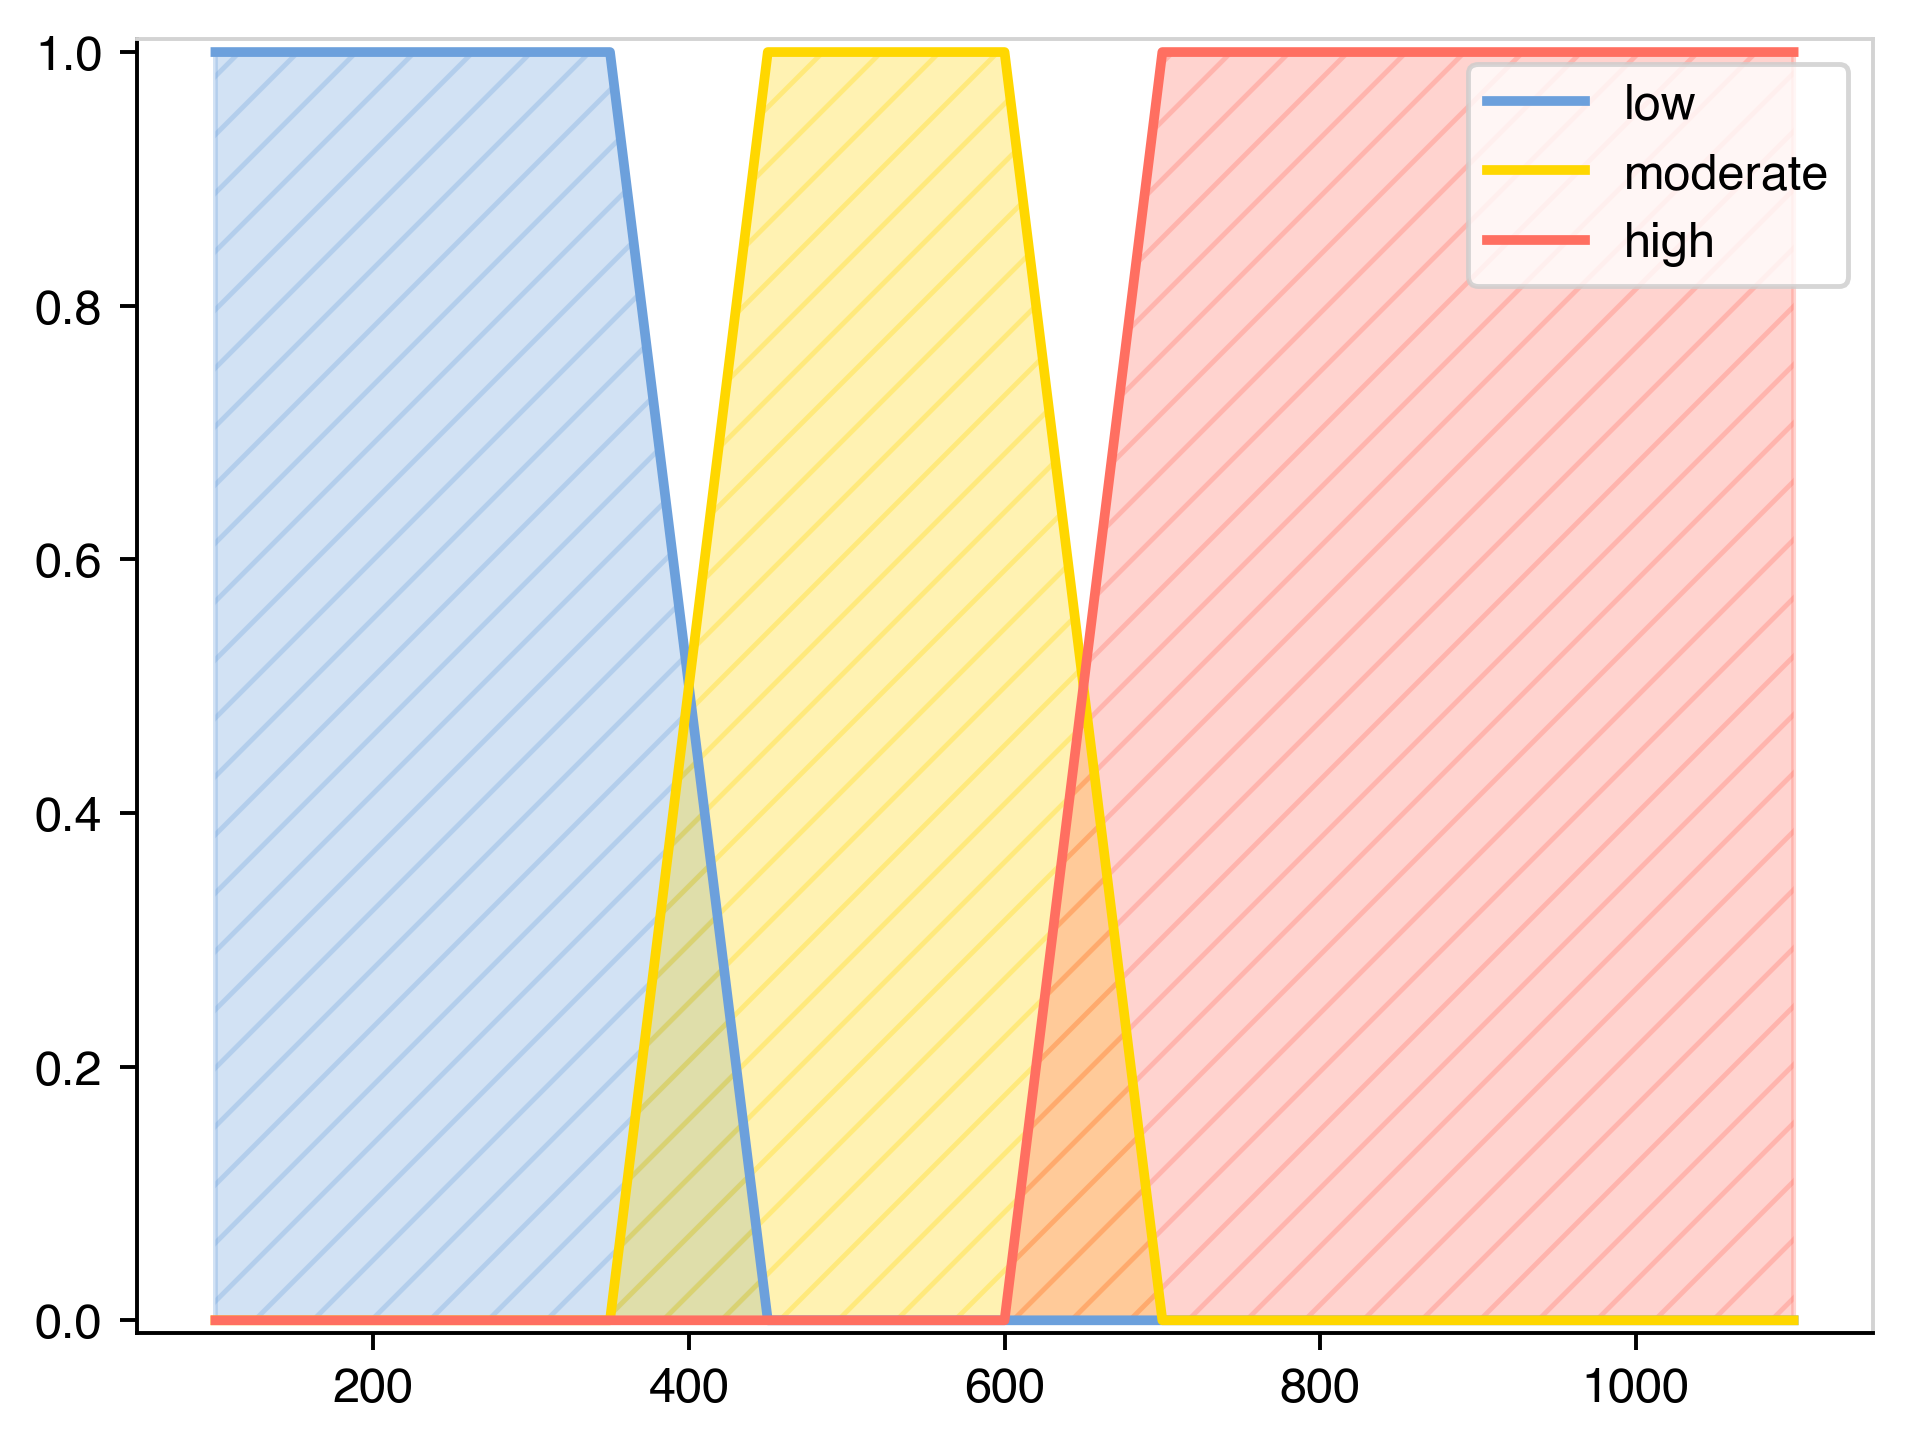

In [23]:
# solar (which is nzm, near-zenith mean)

# Low: (1) transitioning 400-500 to (0)
# Medium support: 450-700
# Medium core: 500-650
# High: (0) transitioning 600-700 to (1)

solar['low'] = plsmf_from_quadruple(solar_uod, 1, 350, 450, 0)
solar['moderate'] = trapmf_from_quintuple(solar_uod, 350, 450, 600, 700, h=1.0)
solar['high'] = plsmf_from_quadruple(solar_uod, 0, 600, 700, 1)

fig, ax = plt.subplots(1)
plot_all_categories(ax, solar, plot_fill=True, line_colors=solar_cats)


background ozone[background]
moderate ozone[moderate]
elevated ozone[elevated]
extreme ozone[extreme]


<Axes: >

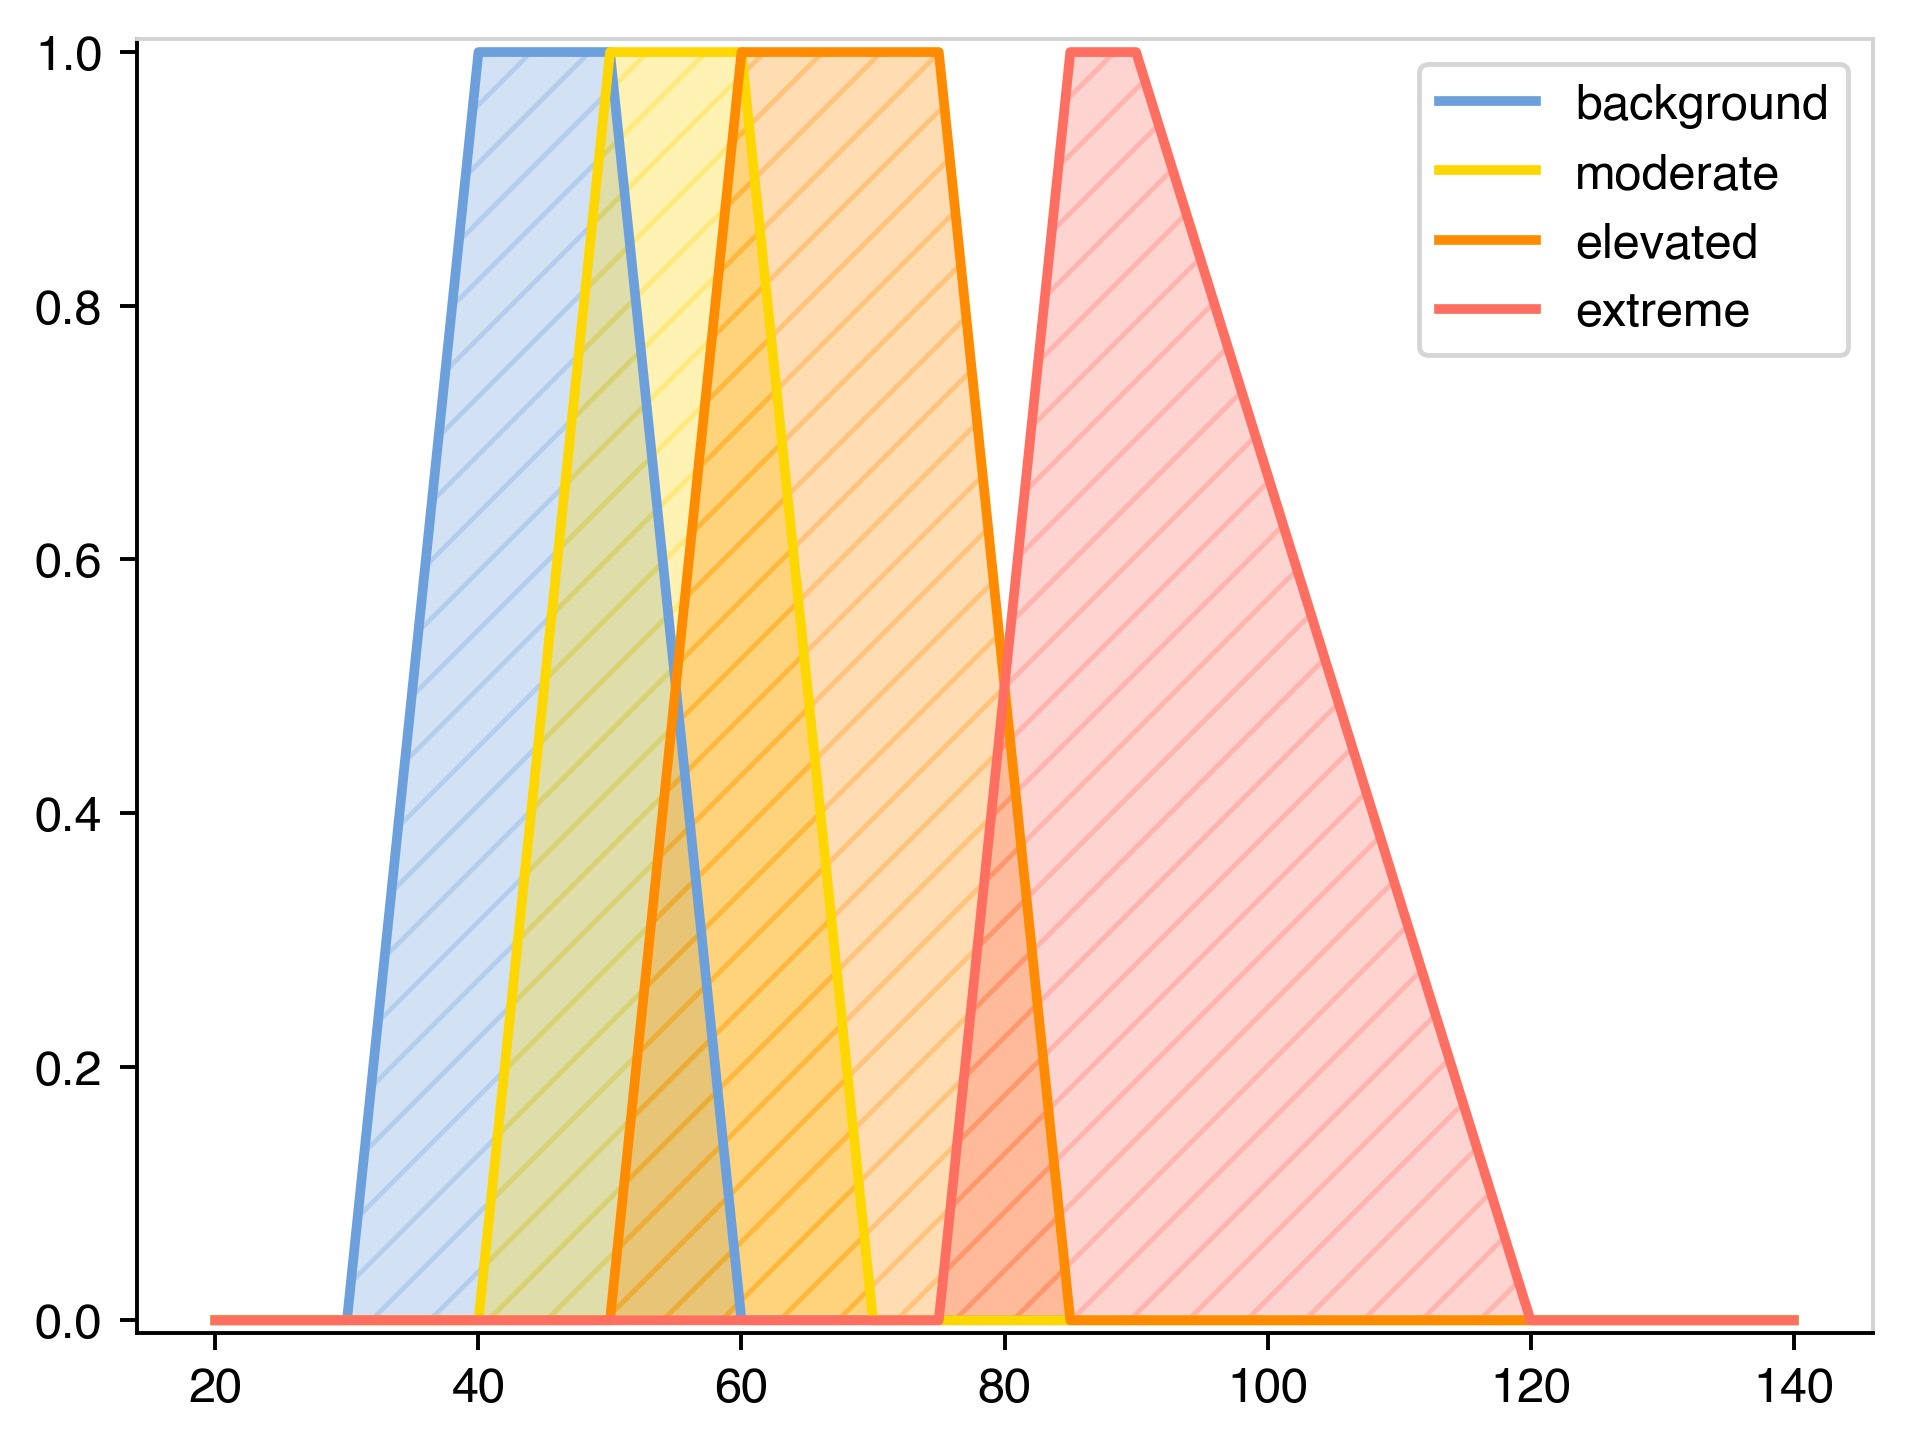

In [24]:
# ozone - we will use similar to LL24

# "background" should rise over time really! Or use "low"... near-background.

# Background trapezium is 20-30-40-50
# Moderate trapezium is 40-50-60-70
# Elevated trapezium is 55-65-75-85
# Extreme trapezium is 70-80-100-140 (can consider h<1 ?!)

ozone['background'] = trapmf_from_quintuple(ozone_uod, 25, 40, 50, 60, h=1.0)
ozone['moderate'] = trapmf_from_quintuple(ozone_uod, 40, 50, 60, 70, h=1.0)
ozone['elevated'] = trapmf_from_quintuple(ozone_uod, 50, 60, 75, 85, h=1.0)
ozone['extreme'] = trapmf_from_quintuple(ozone_uod, 75, 85, 90, 120, h=1.0)
# If we don't catch extreme, we might have h<1 and "fat tail" to aggregation.

fig, ax = plt.subplots(1)
plot_all_categories(ax, ozone, plot_fill=True, line_colors=ozone_cats)

## Setting rules



In [25]:
# Rule 1: Catching cases where ozone cannot build
rule1 = ctrl.Rule((snow['negligible'] | mslp['low'] | wind['breezy']), ozone['background'])

# Rules: snow sufficient, pressure high, wind calm - now depends on solar insolation
rule2 = ctrl.Rule(snow['sufficient'] & mslp['high'] & wind['calm'] & solar['high'], ozone['extreme'])
rule3 = ctrl.Rule(snow['sufficient'] & mslp['high'] & wind['calm'] & solar['moderate'], ozone['elevated']) # sun ok, but conditions good
rule4 = ctrl.Rule(snow['sufficient'] & mslp['high'] & wind['calm'] & solar['low'], ozone['moderate']) # sun weak, but other conditions good

# Another rule needed for early-season inversion with lack of storm/interruption so it builds - 2013/2014
# Memory of days into inversion or previous day etc. Build up to "steady state". Seth has draft of paper. Days into inversion?
# Correlate with NOx?!
# What if output was inversion strength?
# This then feeds into a model using "how strong", "how long", etc to predict ozone build-up

# Could consider a rule with a single use of a new variable that "tips the balance" in a cusp or extreme case
# Maybe soil temp/summer average, percent of max insolation, previous O3/NOx etc

# Cusp cases
rule5 = ctrl.Rule(snow['sufficient'] & mslp['moderate'] & wind['calm'] & solar['high'], ozone['elevated'])
rule6 = ctrl.Rule(snow['sufficient'] & mslp['moderate'] & wind['calm'] & solar['moderate'], ozone['moderate'])
# rule7 = ctrl.Rule(snow['sufficient'] & mslp['moderate'] & wind['calm'] & solar['low'], ozone['background']) # Feels like low-to-moderate!


In [26]:
ozone_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6]) # , rule7])
ozone_simulation = ctrl.ControlSystemSimulation(ozone_ctrl)

In [27]:
def clip_distr(distr, activation):
    return np.minimum(distr, activation)

In [28]:
def plot_activation(x_uod, mf_func, y_value, variable_name,
                    fuzz_color=fave_color, category_label=None,
                    vrbl_unit="cm",
                    return_activation_y=False):
    """This shows activation of ozone .
    """
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    if isinstance(mf_func, np.ndarray):
        y = mf_func
    else:
        raise ValueError("Pass array for function.}")

    # Plot the membership function
    ax.plot(x_uod, y, color=fuzz_color, linewidth=2)

    # Shade plot between y=0 and activation level (y_value) only where y is non-zero
    ax.fill_between(x_uod, np.minimum(y, y_value), color=fuzz_color, alpha=0.3, hatch='//')

    # Horizontal line at y_value
    ax.axhline(y=y_value, color='grey', linestyle='--', alpha=0.6)  # Horizontal grey line


    # Set titles and labels
    ax.set_title(f'Activation of {vrbl_unit} {variable_name}     //'
                 f'        category: {category_label}', fontsize=14)
    ax.set_xlabel(f'{variable_name} ({vrbl_unit})', fontsize=12)
    ax.set_ylabel('Degree of membership $\mu$', fontsize=12)
    ax.set_ylim(-0.1, 1.1)
    ax.axhline(y=1, color='grey', linestyle='--', alpha=0.7)
    ax.axhline(y=0, color='grey', linestyle='--', alpha=0.7)
    ax.grid(False)

    style_axes(ax)

    if return_activation_y:
        # y_return is y clipped to the y_value
        # y_return = np.minimum(y, y_value)
        y_return = clip_distr(y, y_value)
        return fig, ax, y_return

    return fig, ax

In [29]:
def simulate_ozone(snow, mslp, wind, solar):
    """Simulate ozone levels based on input values and plot the result.

    Args:
        snow (float): Snow input value.
        mslp (float): Mean sea level pressure input value.
        wind (float): Wind input value.
        solar (float): Solar input value.

    Returns:
        float: Predicted ozone level.
    """
    ozone_simulation.input['snow'] = snow
    ozone_simulation.input['mslp'] = mslp
    ozone_simulation.input['wind'] = wind
    ozone_simulation.input['solar'] = solar

    ozone_simulation.compute()
    print("Predicted Ozone Level:", ozone_simulation.output['ozone'])
    ozone.view(sim=ozone_simulation)

    # TODO - extend to percentile defuzzification?
    # TODO our own plot to add lines
    return ozone_simulation.output['ozone']


Predicted Ozone Level: 80.47091722595091


/Users/johnlawson/anaconda3/envs/clyfar/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


np.float64(80.47091722595091)

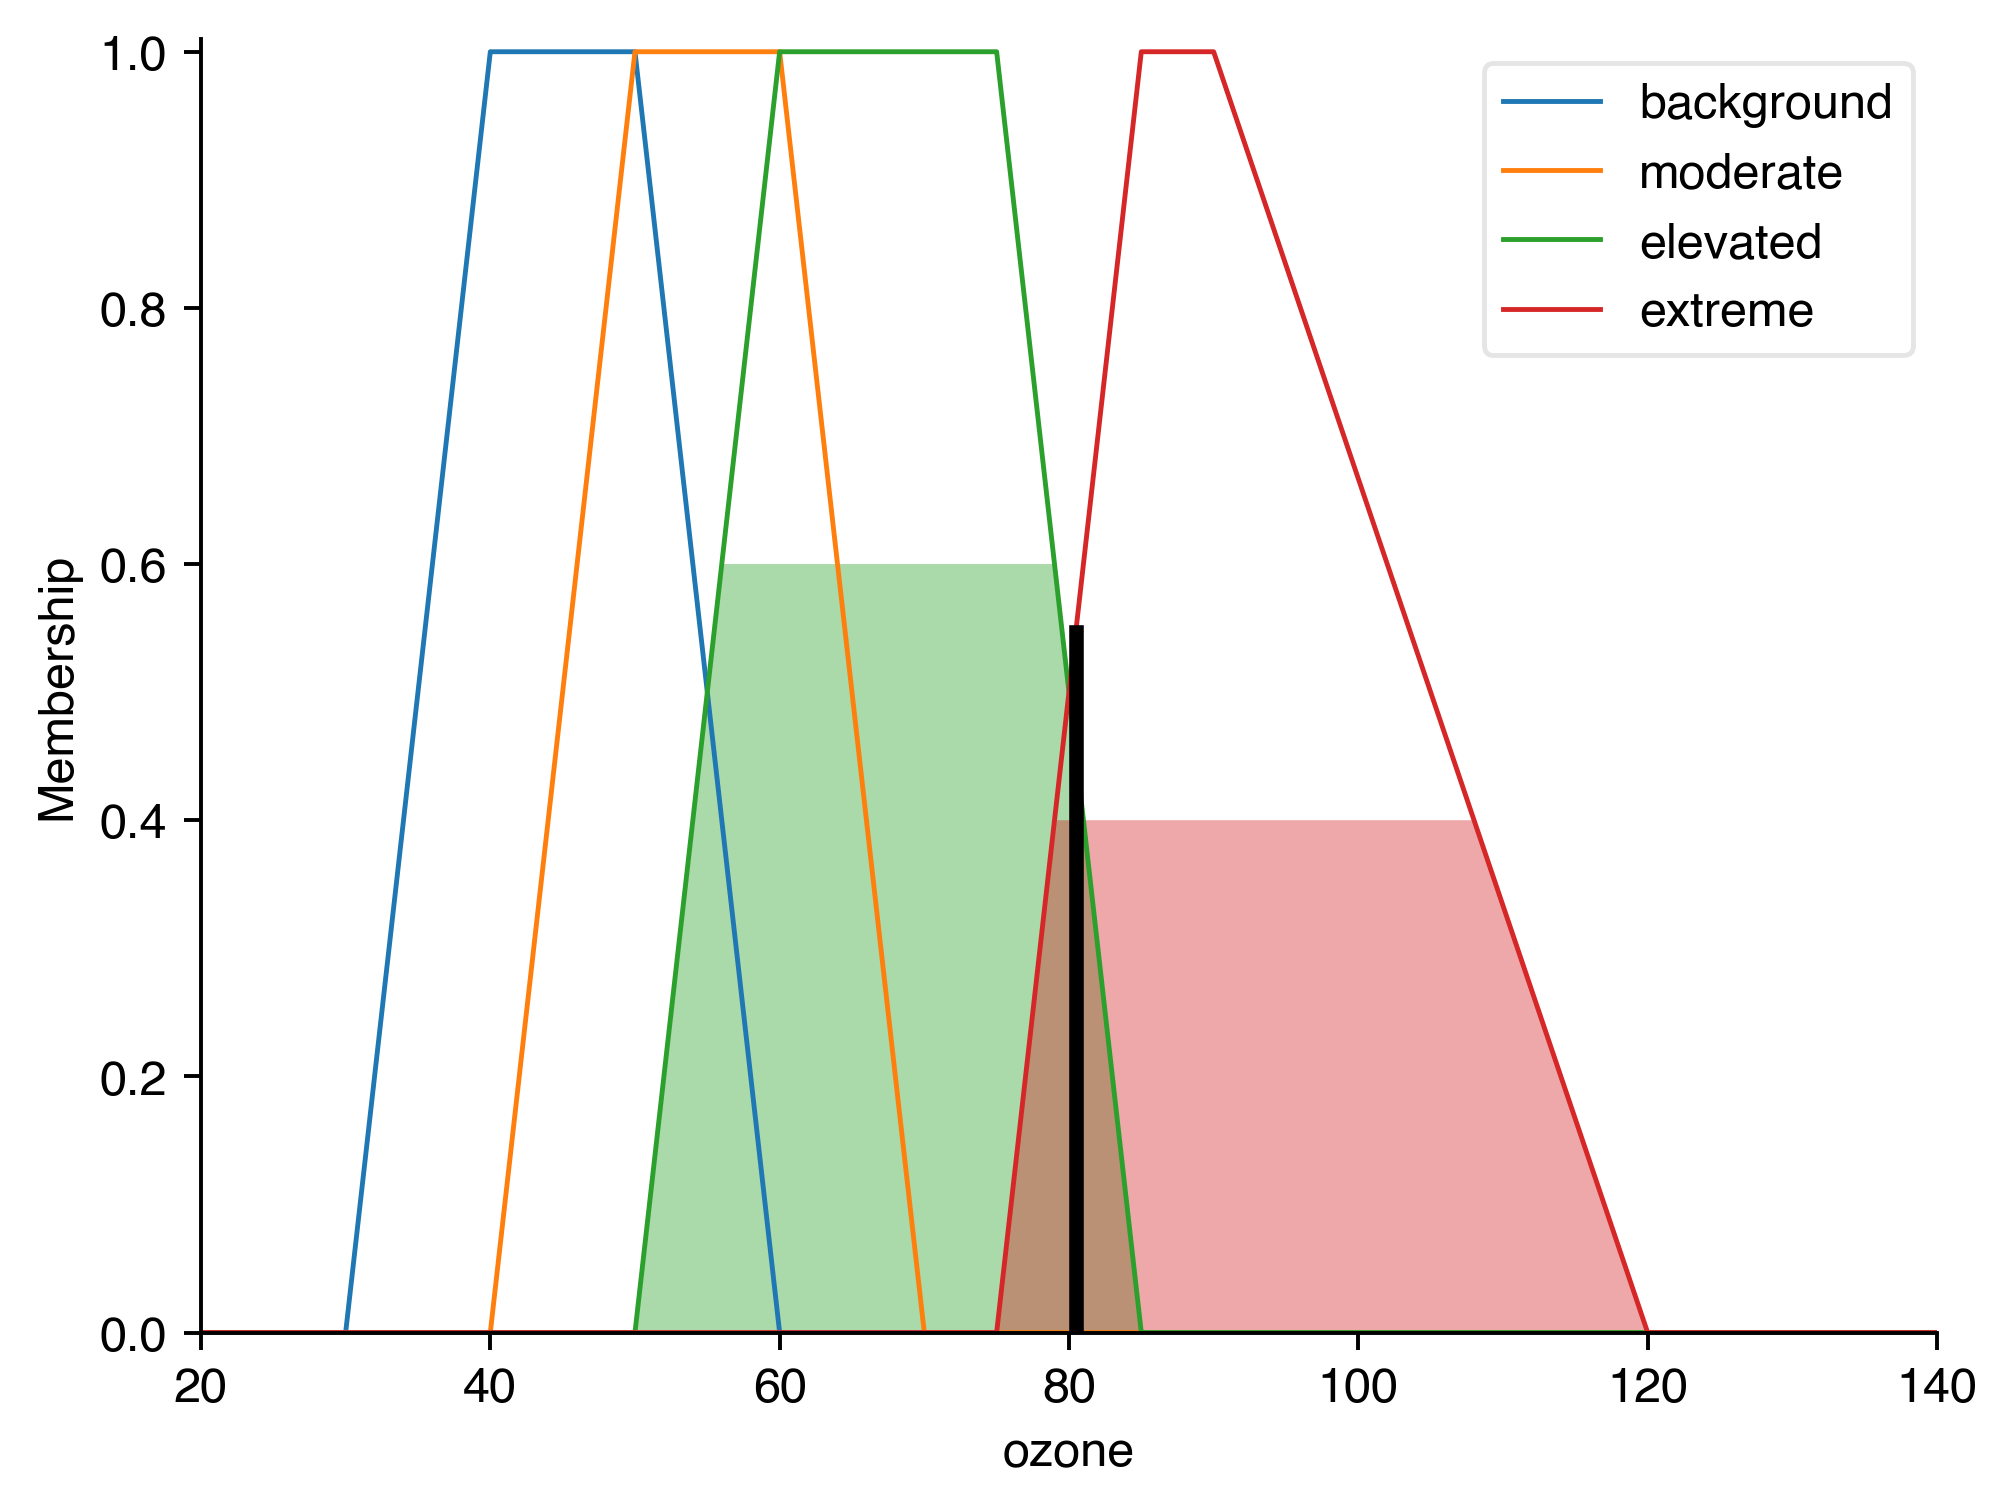

In [30]:
# High ozone day
simulate_ozone(175, 1035E2, 0.8, 640)

In [31]:
# Show the aggregation step here like Fig 7 in the preprint


Predicted Ozone Level: 51.75981448820956


np.float64(51.75981448820956)

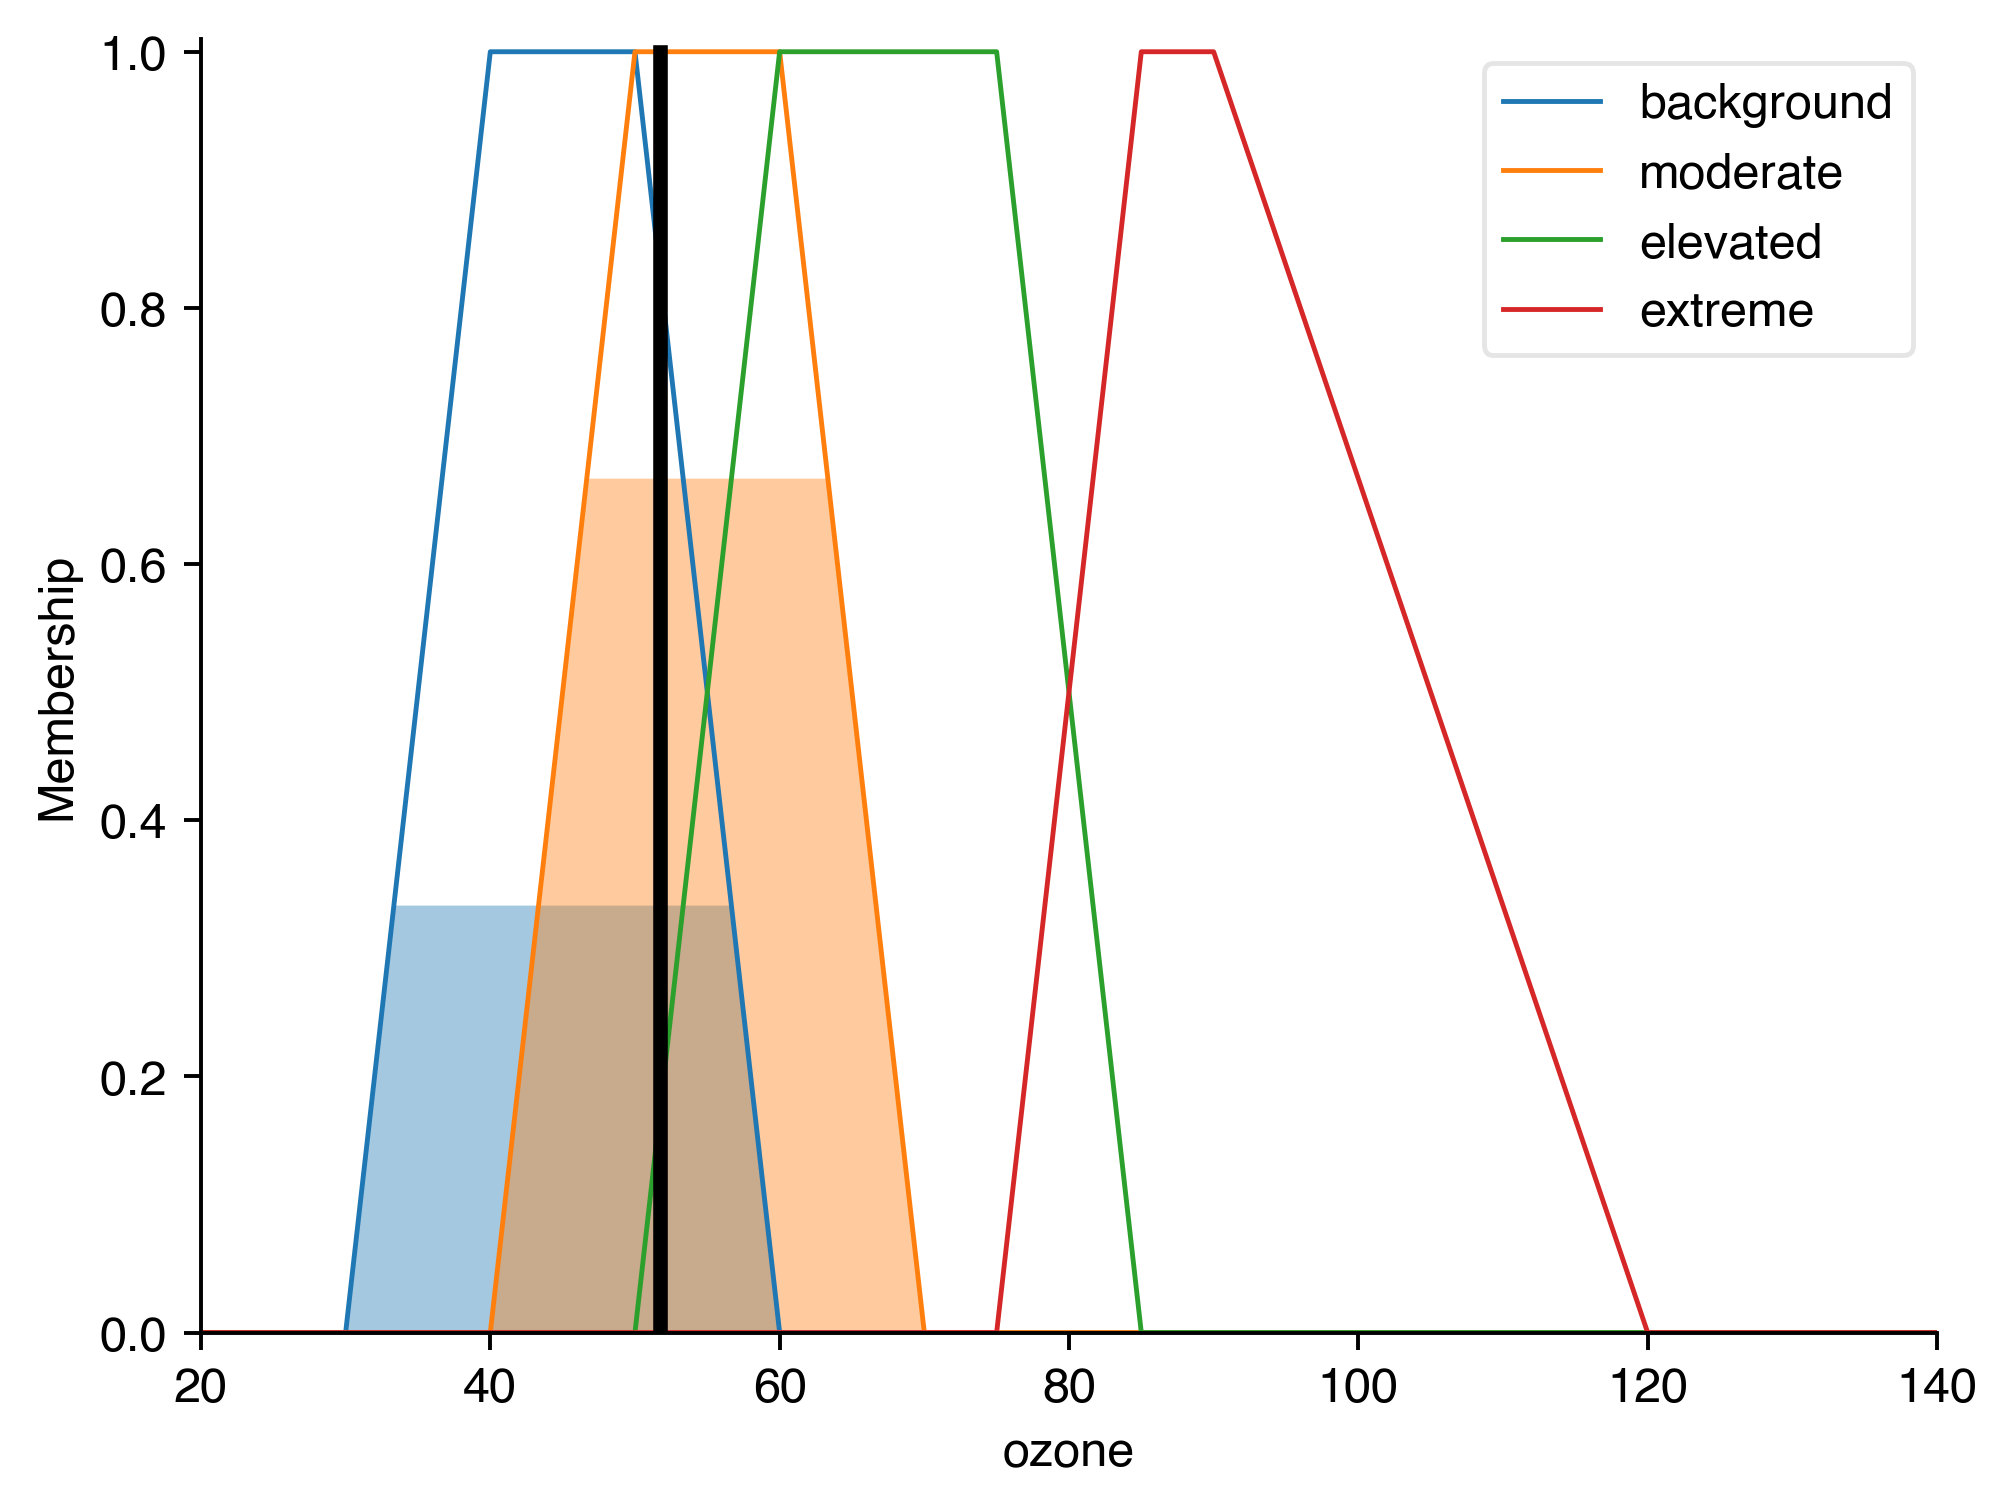

In [32]:
# Cusp day
simulate_ozone(80, 1016E2, 1.2, 520)


Predicted Ozone Level: 45.00000000000001


np.float64(45.00000000000001)

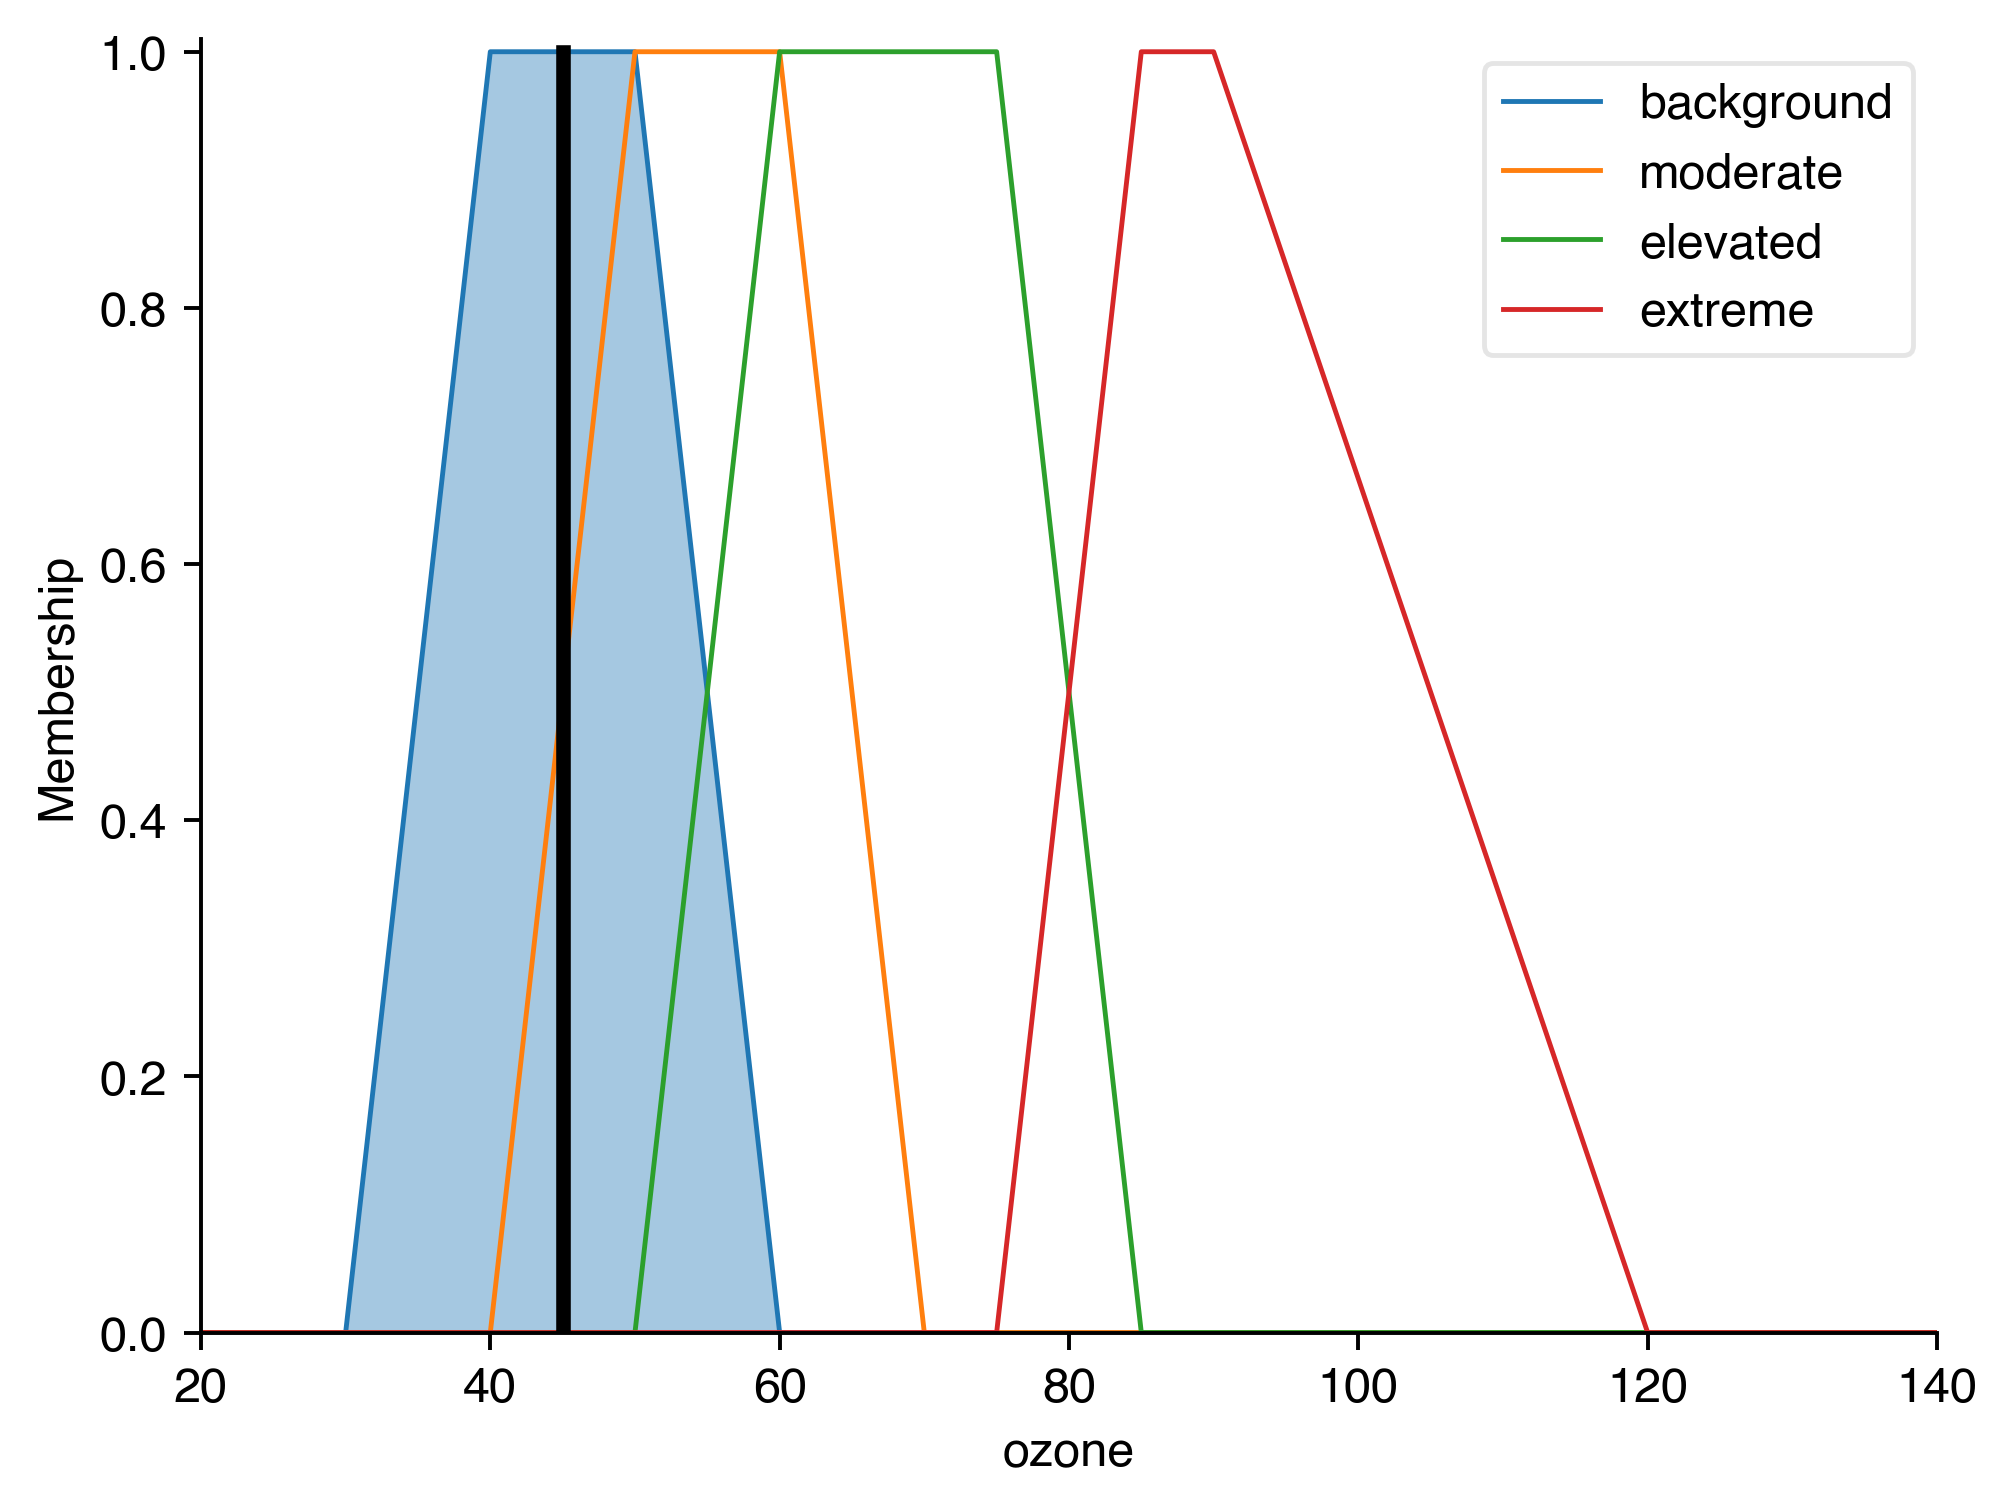

In [33]:
# Background day
simulate_ozone(15, 1009E2, 1.9, 400)


Predicted Ozone Level: 93.83333333333337


np.float64(93.83333333333337)

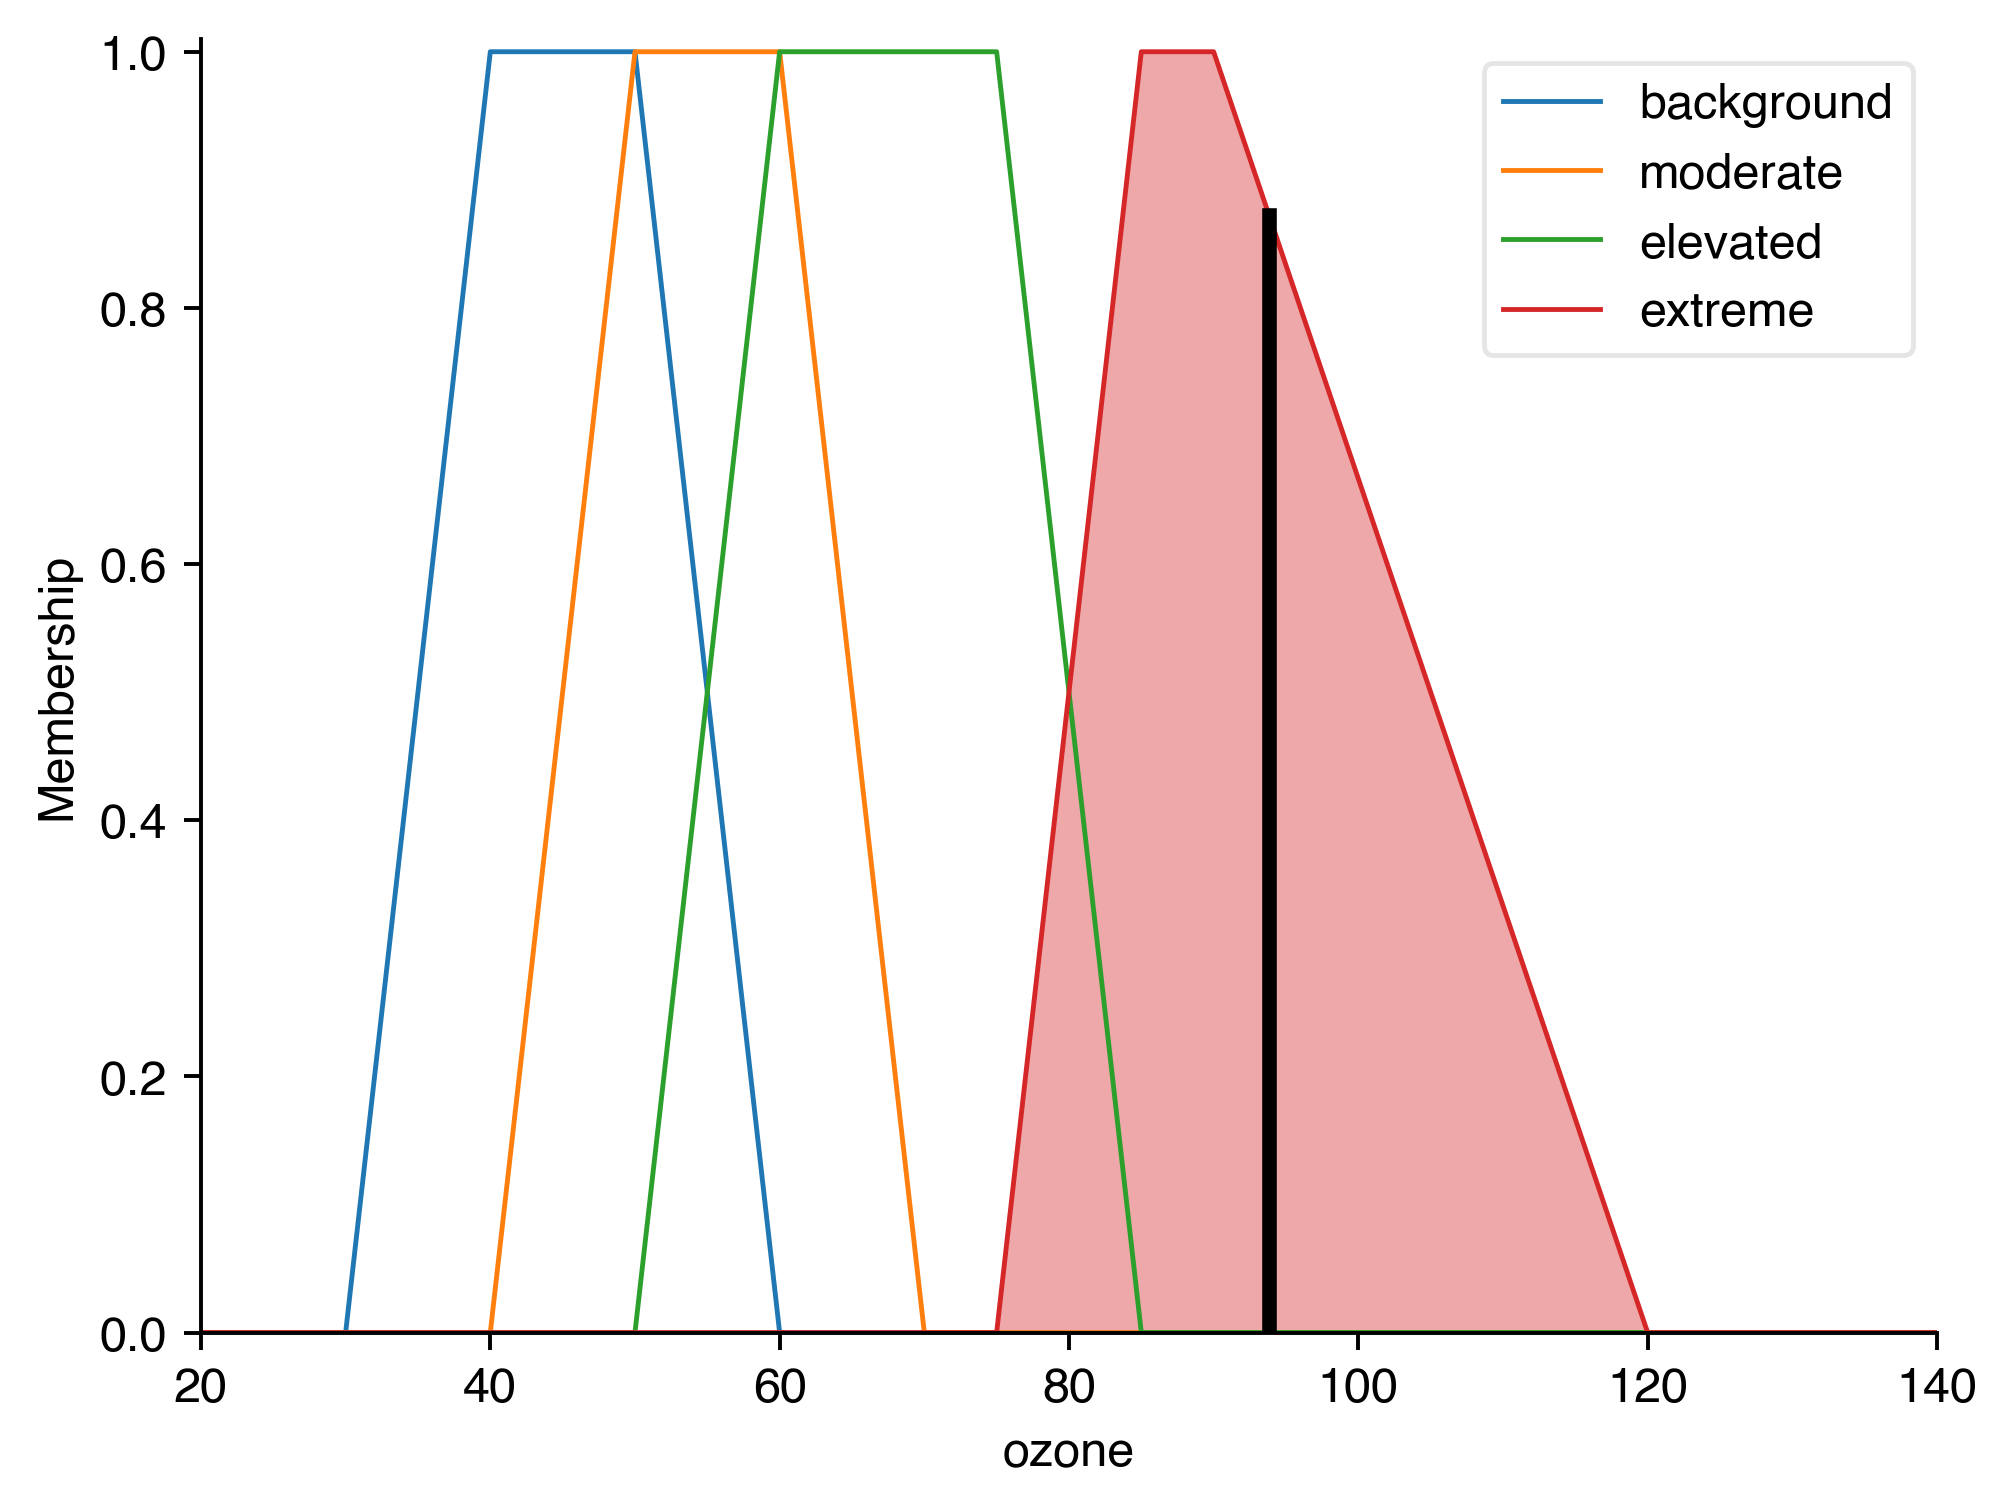

In [34]:
# Messed up summer day
simulate_ozone(300, 1050E2, 0.5, 1100)

## Data load and evaluation
We will load the observations, make inference/hindcasts, and produce reasonable *best*-, *average*-, and *worst*-case scenarios based on 10th, 50th, and 90th percentiles of the ozone possibility distribution $\pi$.


In [35]:
df, meta_df = ObsData.load_dfs("../data", f"UB_obs_{year}.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,solar_radiation,dew_point_temperature_set_1d,soil_temp,soil_temp_set_2,soil_temp_set_3,soil_temp_set_4,soil_temp_set_5,NOx_concentration,ozone_concentration,PM_25_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2023-12-01 00:00:00+00:00,-5.0,100982.062500,2438.399902,NaN,-8.05,83192.117188,NaN,101655.351562,190.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:05:00+00:00,-6.0,100982.062500,2438.399902,NaN,-8.04,83192.117188,NaN,101730.187500,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:10:00+00:00,-5.0,100982.062500,365.760010,NaN,-8.05,83192.117188,NaN,101655.351562,170.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:15:00+00:00,-6.0,100982.062500,365.760010,NaN,-8.04,83192.117188,NaN,101730.187500,180.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:16:00+00:00,-5.6,100982.062500,365.760010,-8.3,-8.35,83192.117188,NaN,101700.187500,0.0,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:20:00+00:00,-6.0,100982.062500,365.760010,NaN,-8.04,83192.117188,NaN,101730.187500,170.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:25:00+00:00,-6.0,100982.062500,365.760010,NaN,-8.04,83192.117188,NaN,101730.187500,170.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:30:00+00:00,-6.0,101015.921875,365.760010,NaN,-8.04,83220.023438,NaN,101764.312500,150.0,2.058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01 00:35:00+00:00,-6.0,101015.921875,365.760010,NaN,-8.04,83220.023438,NaN,101764.312500,160.0,1.543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
repr_mslp = do_repval_mslp(df, mslp_stids)
repr_solar = do_repval_solar(df, solar_stids)
repr_snow = do_repval_snow(df, snow_stids)
repr_wind = do_repval_wind(df, wind_stids)
repr_ozone = do_repval_ozone(df, ozone_stids)


### Graphical representation of the FIS

In [37]:
# Fuzzify inputs
snow_value = 87
wind_value = 1.85
solar_value = 640
mslp_value = 1033E2


Activation of Rule 2 (Extreme Ozone): 0.4


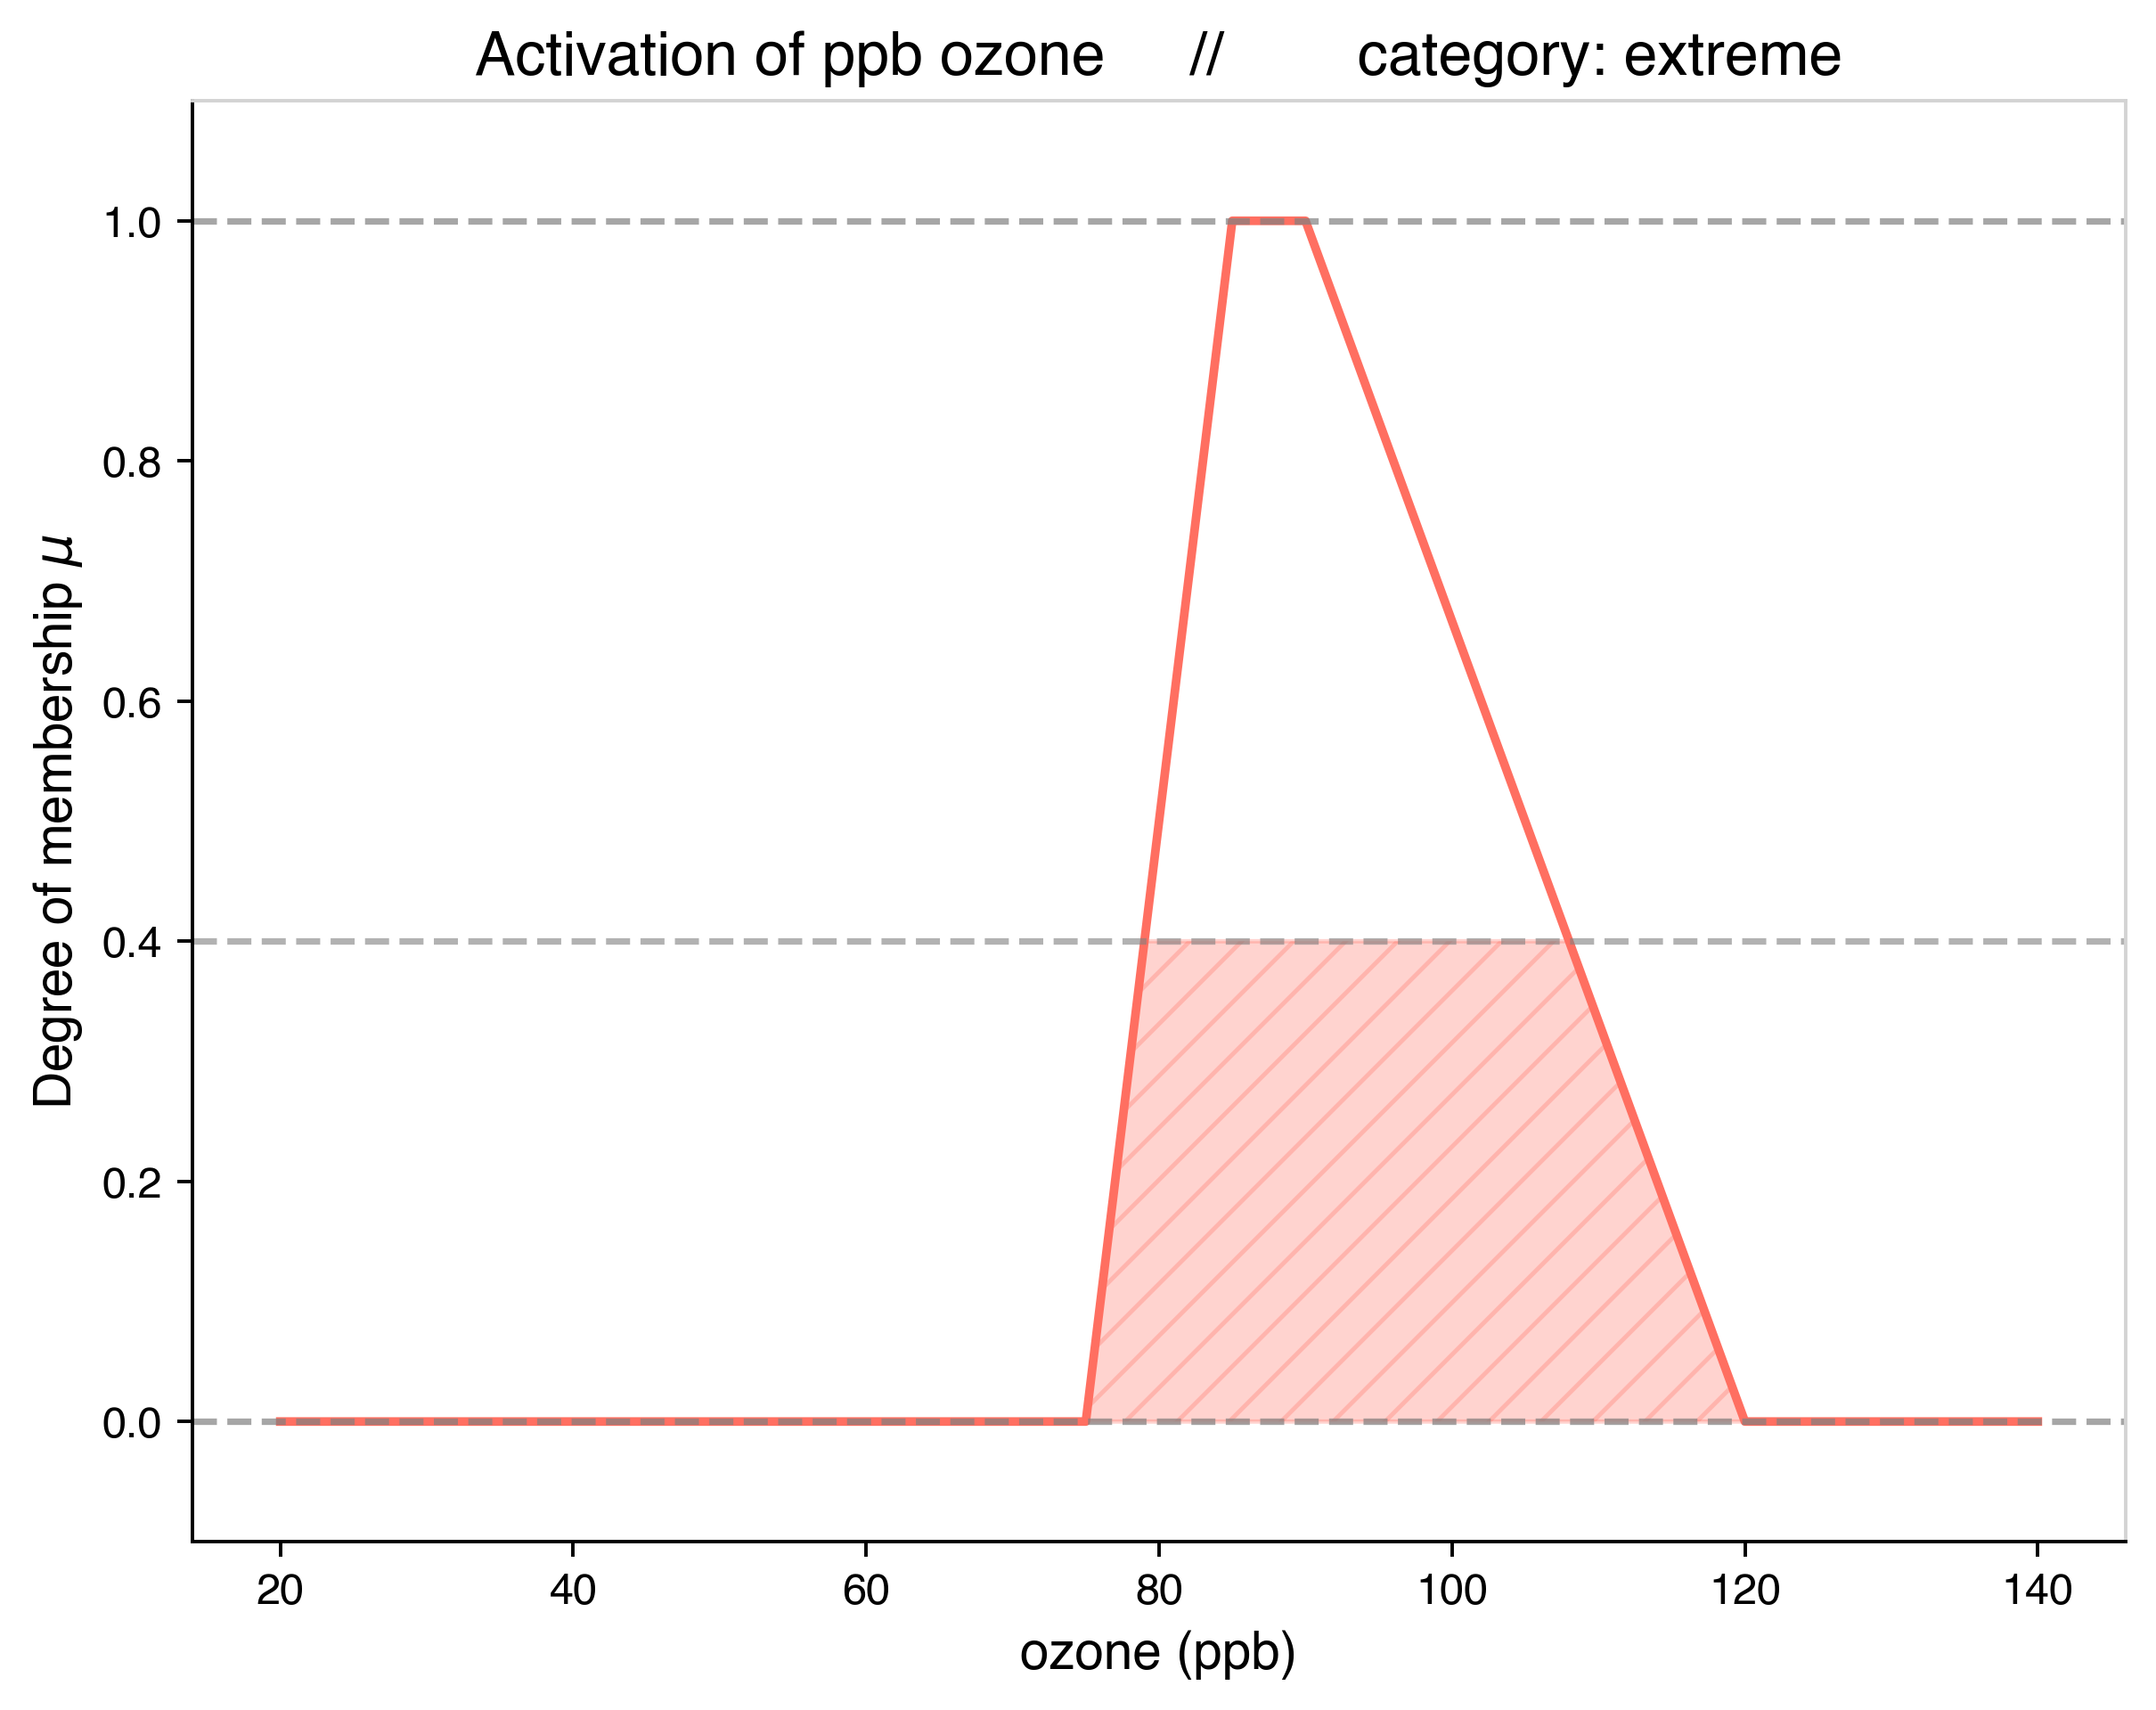

In [38]:

# We'll show rule 2:
# rule2 = ctrl.Rule(snow['sufficient'] & mslp['high'] & wind['calm'] & solar['high'], ozone['extreme'])
# Extreme ozone is possible if snow is sufficient, pressure is high, wind is calm, and solar is high

# Fuzzify snow value (sufficient)
snow_membership = np.interp(snow_value, snow_uod, snow['sufficient'].mf)

# Fuzzify wind value (calm)
wind_membership= np.interp(wind_value, wind_uod, wind['calm'].mf)

# Fuzzify solar value (high)
solar_membership = np.interp(solar_value, solar_uod, solar['high'].mf)

# Fuzzify MSLP value (high)
mslp_membership = np.interp(mslp_value, mslp_uod, mslp['high'].mf)

# Activation of ozone based on Rule 2
activation2 = min(snow_membership, mslp_membership, wind_membership, solar_membership)
print(f"Activation of Rule 2 (Extreme Ozone): {activation2}")

fig, ax, y2 = plot_activation(
    x_uod=ozone_uod,
    mf_func=ozone['extreme'].mf,
    y_value=activation2,
    fuzz_color=ozone_cats["extreme"],
    category_label="extreme",
    variable_name="ozone",
    vrbl_unit="ppb",
    return_activation_y=True,
    # save_path=os.path.join(output_dir, "activation_elevated.pdf")
)


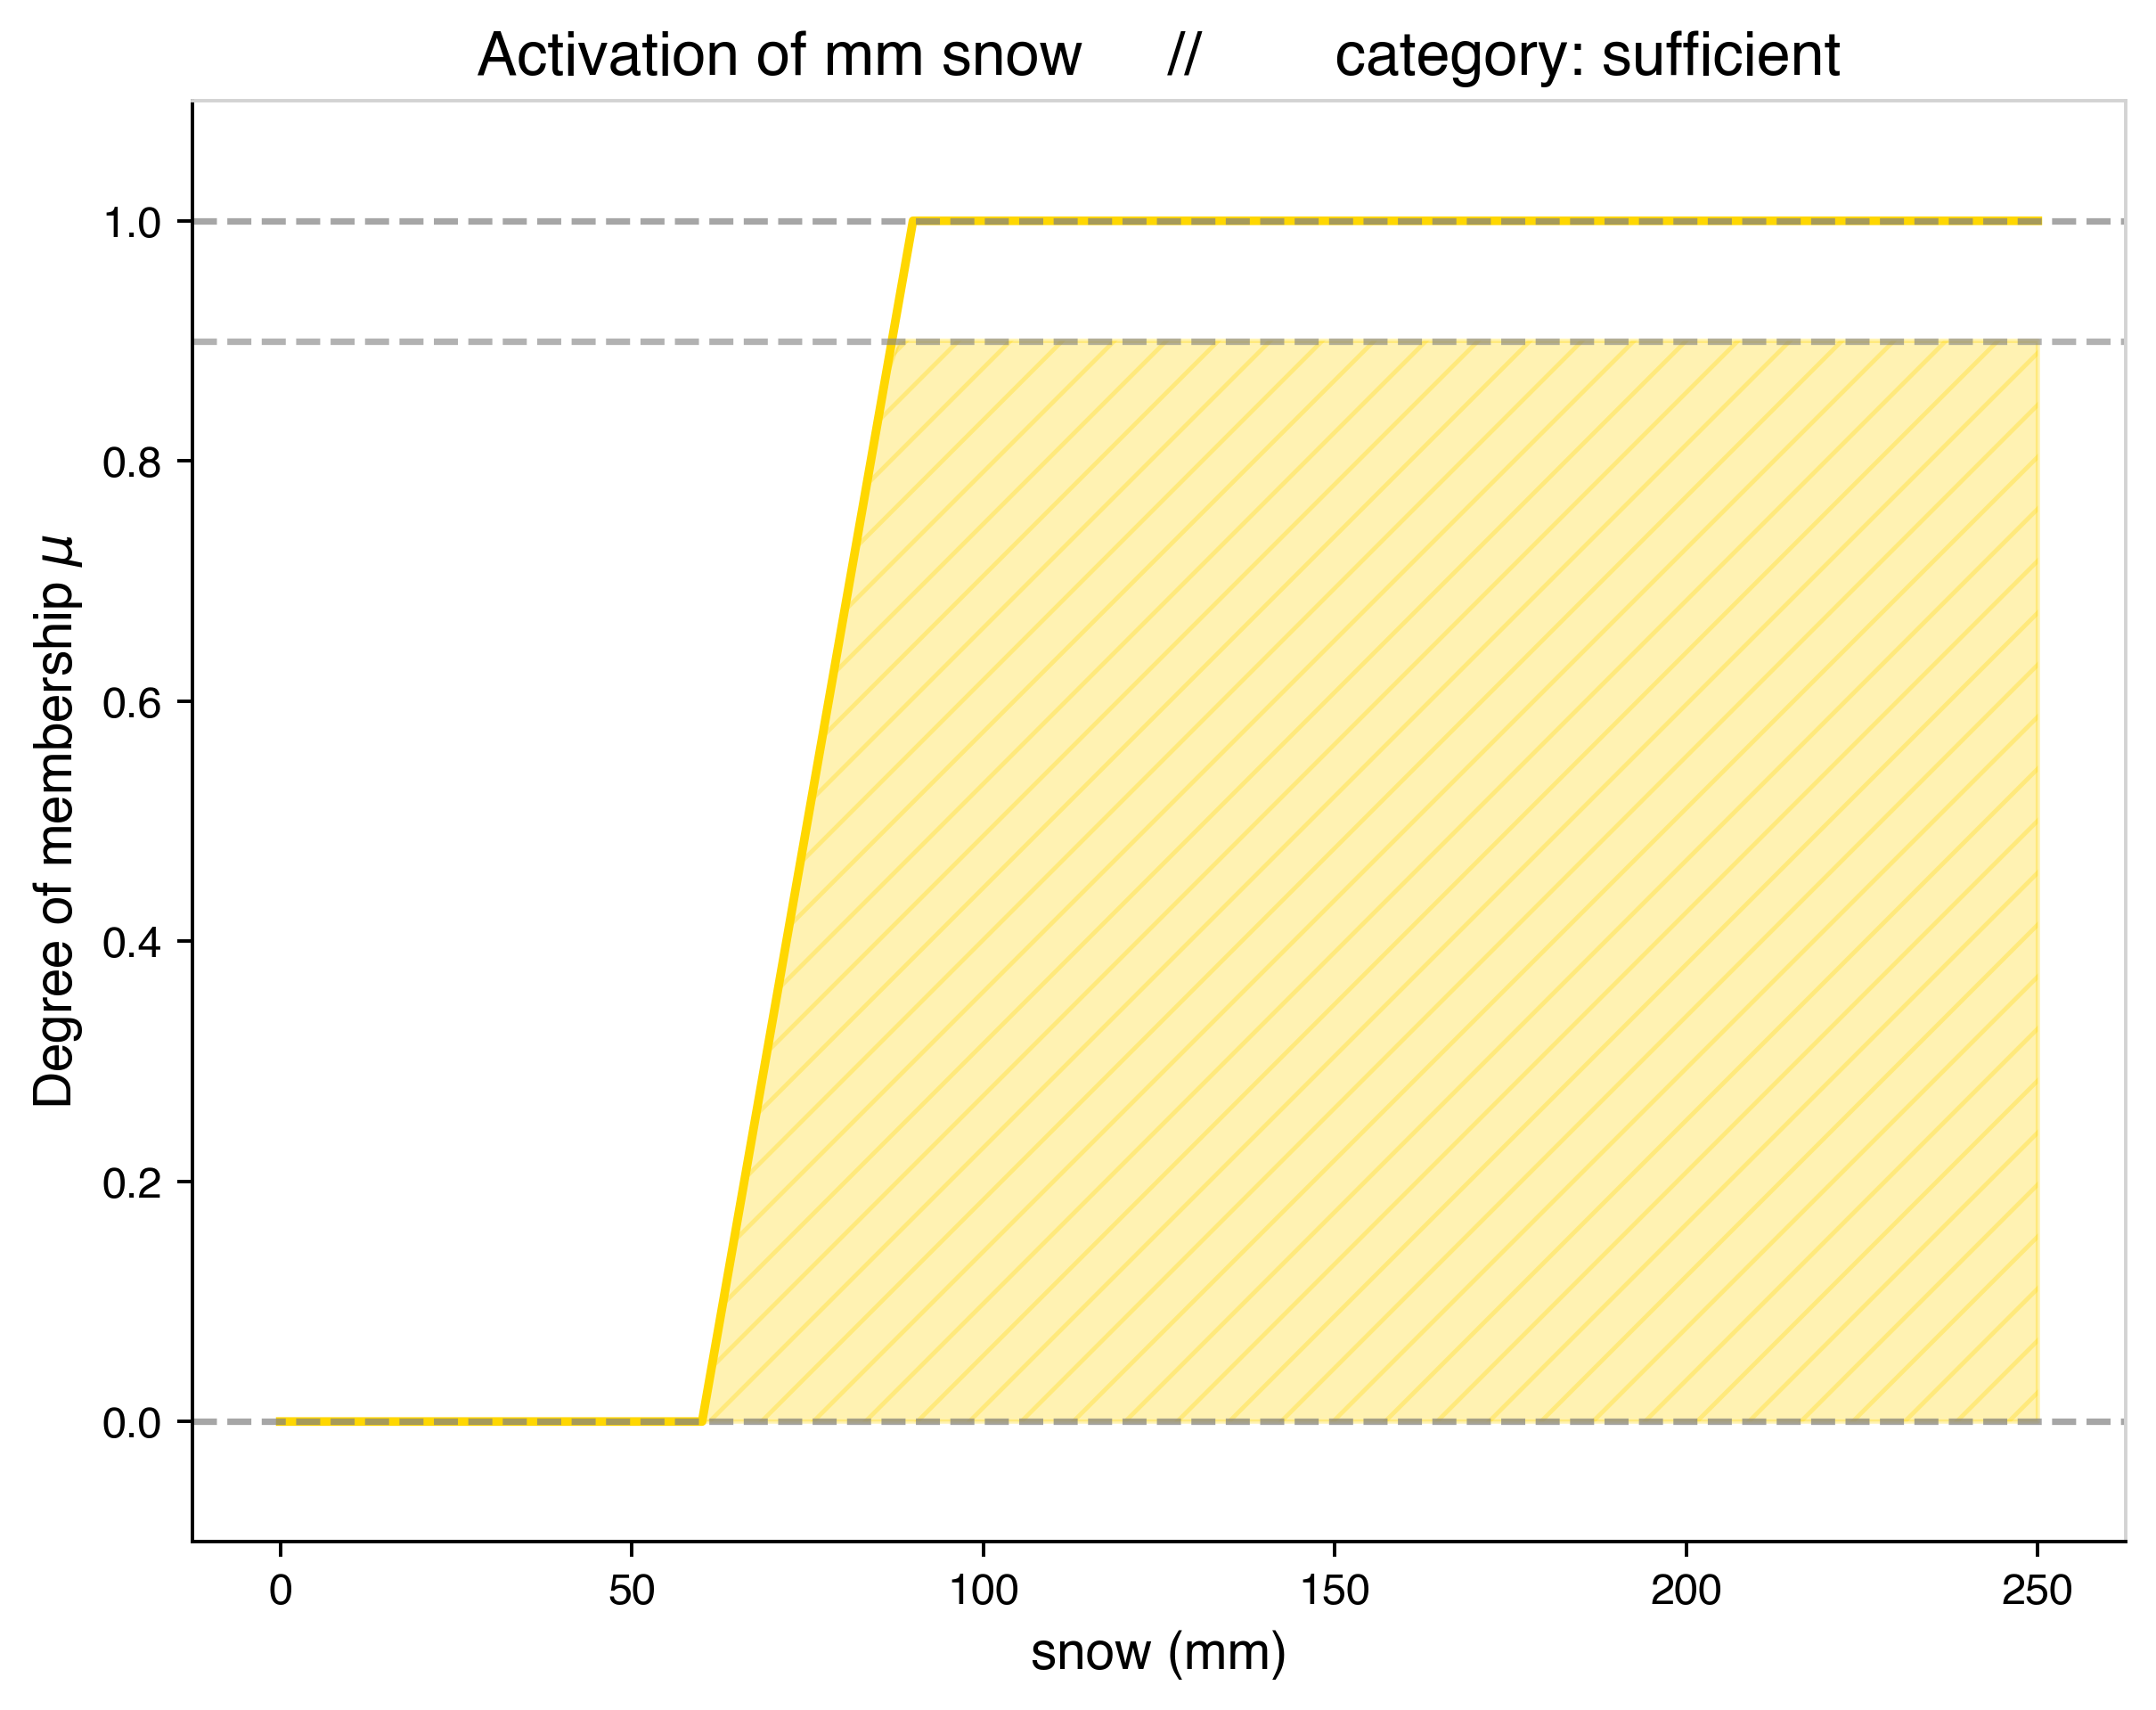

In [39]:
# Look just at activation of from snow
fig, ax, snow_y = plot_activation(x_uod=snow_uod, mf_func=snow['sufficient'].mf, y_value=snow_membership,
                              fuzz_color=snow_cats['sufficient'], category_label="sufficient", variable_name="snow",
                              vrbl_unit="mm", return_activation_y=True)

In [40]:


# activation_mf_arrays = {
#     "Snow": snow_y,
    # "MSLP": mslp_membership,
    # "Wind": wind_membership,
    # "Solar": solar_membership,
# }

# Make these the same as the rule examples above depending on rule itself
# plot_colors = {
#     "Snow": snow_cats["sufficient"],
    # "MSLP": mslp_cats["high"],
    # "Wind": wind_cats["calm"],
    # "Solar": solar_cats["high"],
# }

# fig, ax, y_agg = make_mf_figure(
#     activation_mf_arrays,
#     plot_union=True,
#     plot_colors=plot_colors,
#     return_aggregated=True,
    # save_path=os.path.join(output_dir, "combined_activation_union.pdf")
# )

# fig.show()


Activation1 (Moderate Ozone): 0.4


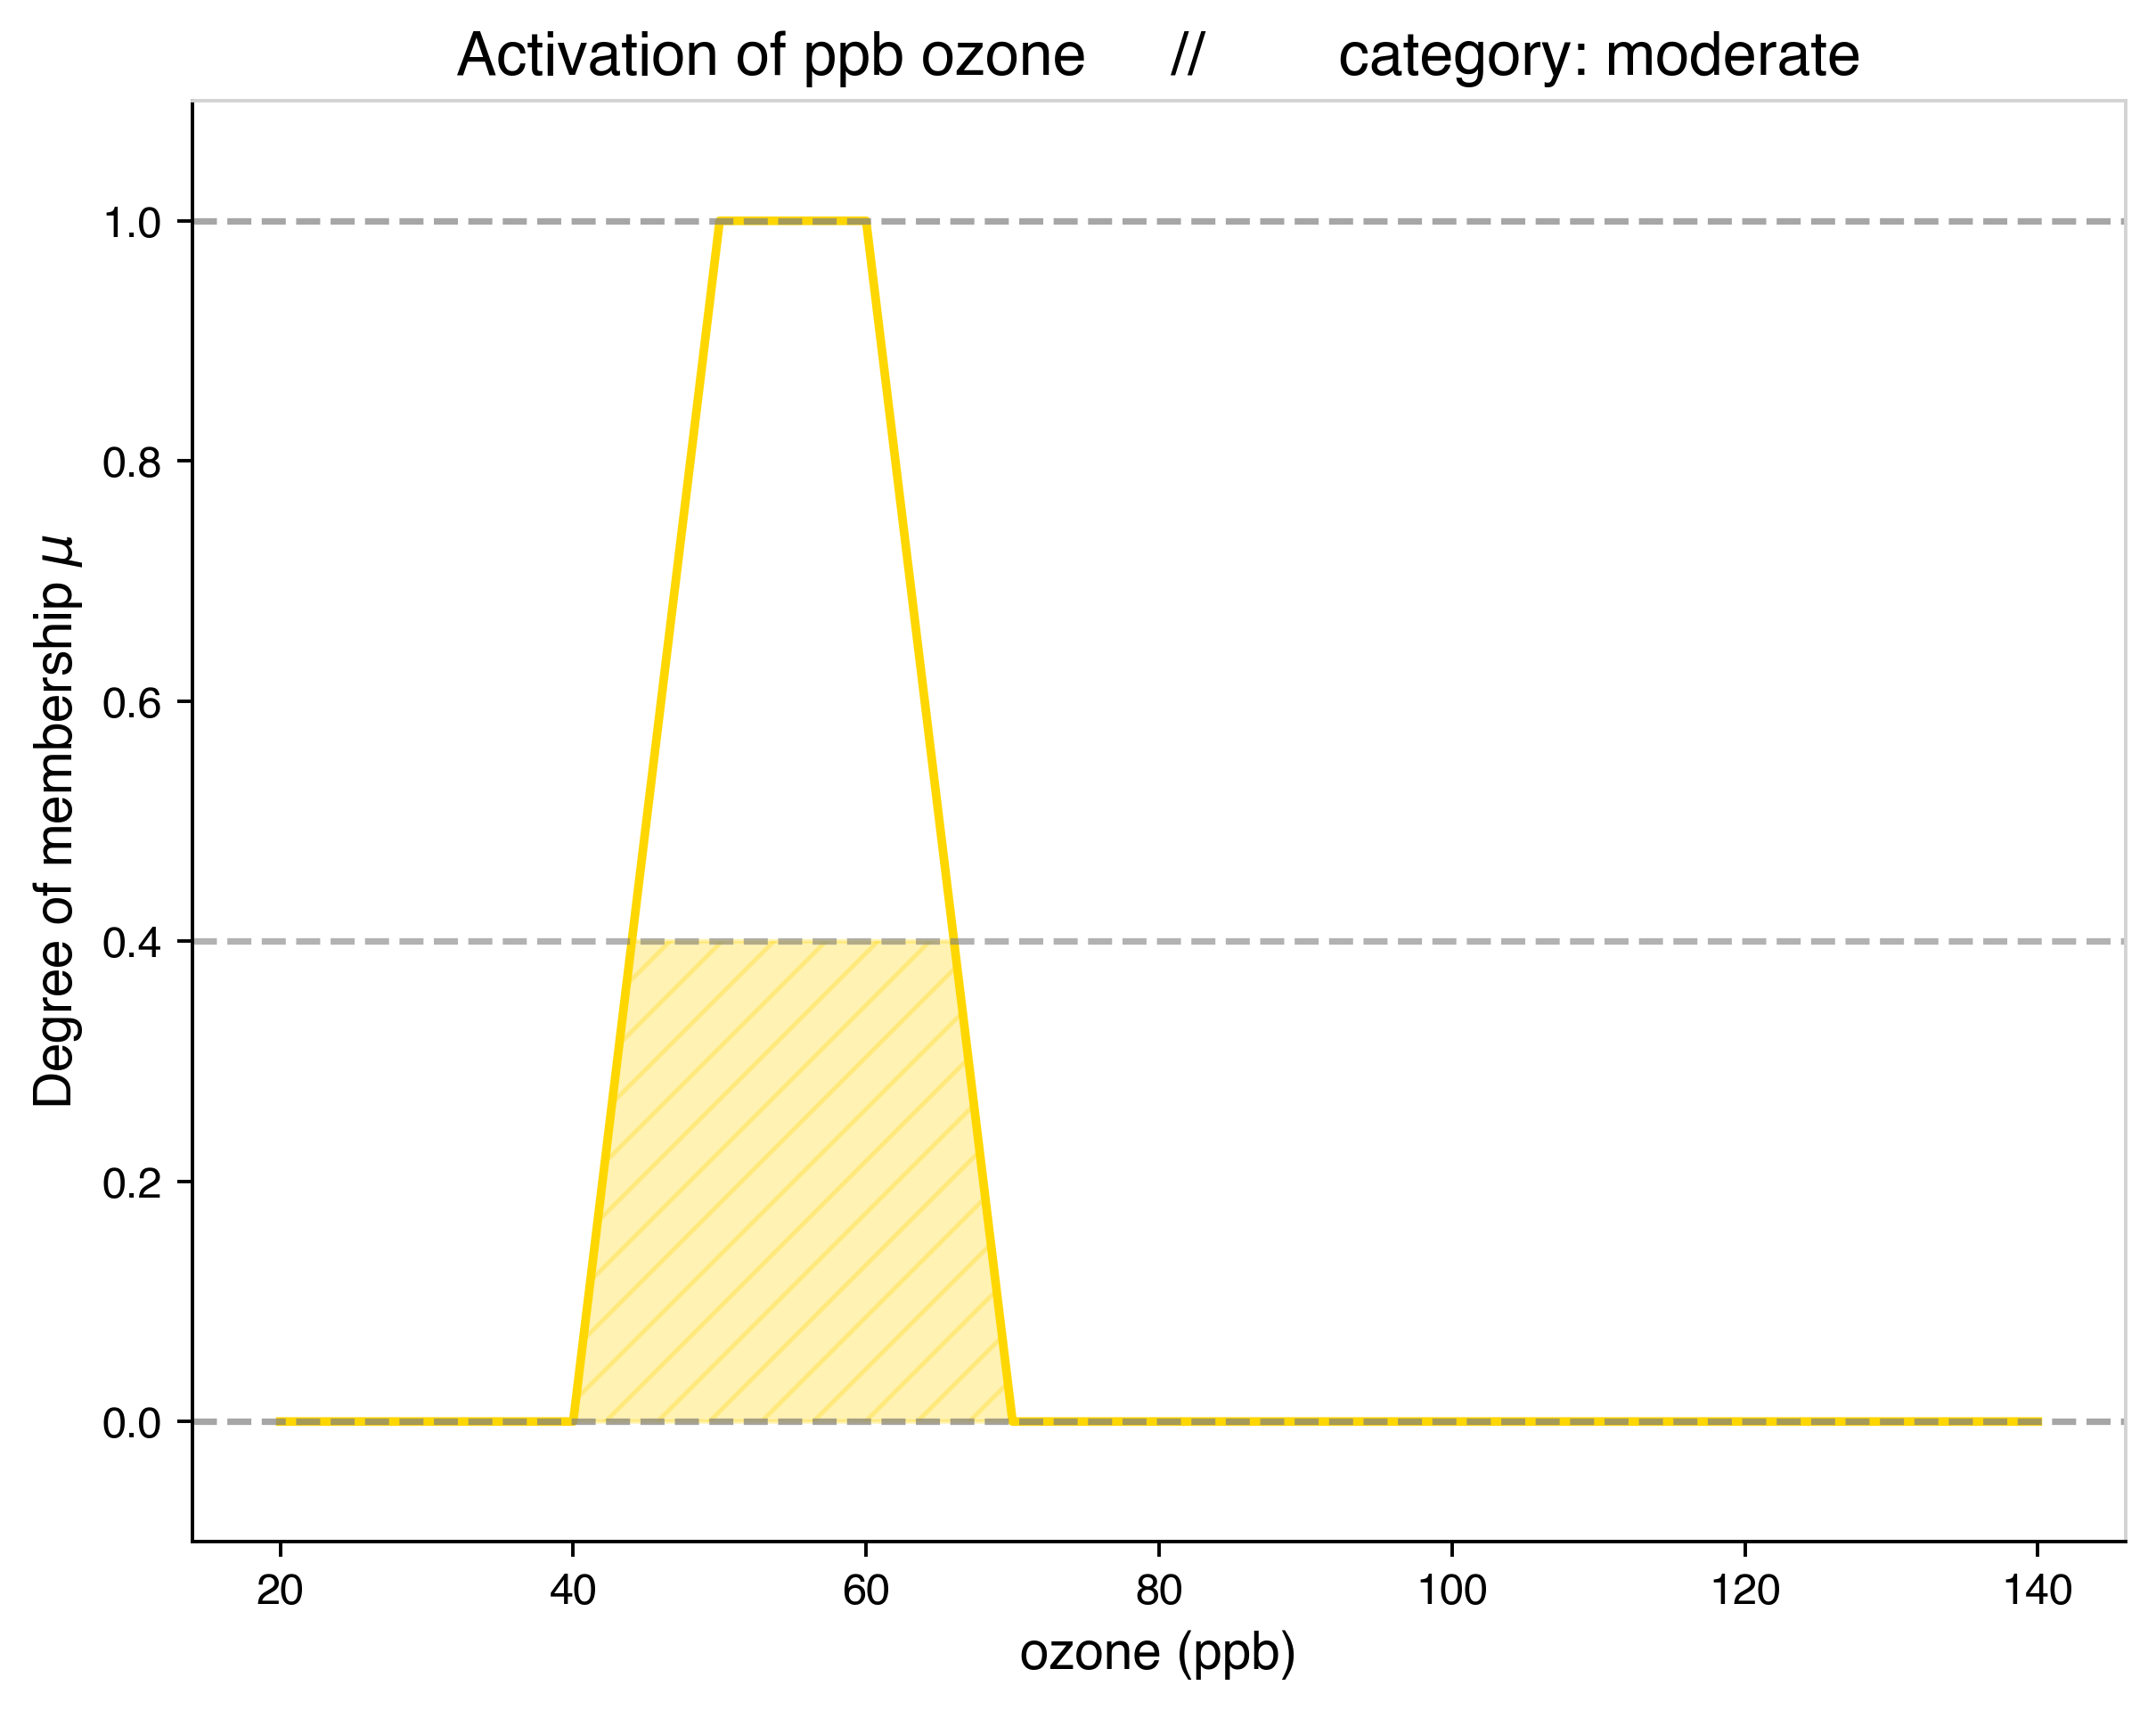

In [41]:

# Let's show the activation of Rule 6 as well
# rule6 = ctrl.Rule(snow['sufficient'] & mslp['moderate'] & wind['calm'] & solar['moderate'], ozone['moderate'])
# Moderate ozone is possible if snow is sufficient, pressure is moderate, wind is calm, and solar is moderate

# Fuzzify snow value (sufficient)
snow_membership = np.interp(snow_value, snow_uod, snow['sufficient'].mf)

# Fuzzify wind value (calm)
wind_membership = np.interp(wind_value, wind_uod, wind['calm'].mf)

# Fuzzify solar value (moderate)
solar_membership = np.interp(solar_value, solar_uod, solar['moderate'].mf)

# Fuzzify MSLP value (moderate)
mslp_membership = np.interp(mslp_value, mslp_uod, mslp['moderate'].mf)


# Activation of ozone based on Rule 6
activation6 = min(snow_membership, mslp_membership, wind_membership, solar_membership)
print(f"Activation1 (Moderate Ozone): {activation6}")

# Combine the two activations using maximum (OR operation)
# combined_activation = max(activation2, activation6)
# print(f"Combined Activation: {combined_activation}")

fig, ax, y1 = plot_activation(
    x_uod=ozone_uod,
    mf_func=ozone['moderate'].mf,
    y_value=activation6,
    fuzz_color=ozone_cats["moderate"],
    category_label="moderate",
    variable_name="ozone",
    vrbl_unit="ppb",
    return_activation_y=True,
    # save_path=os.path.join(output_dir, "activation_elevated.pdf")
)


Rule 1
Rule 2


/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_99560/183737104.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


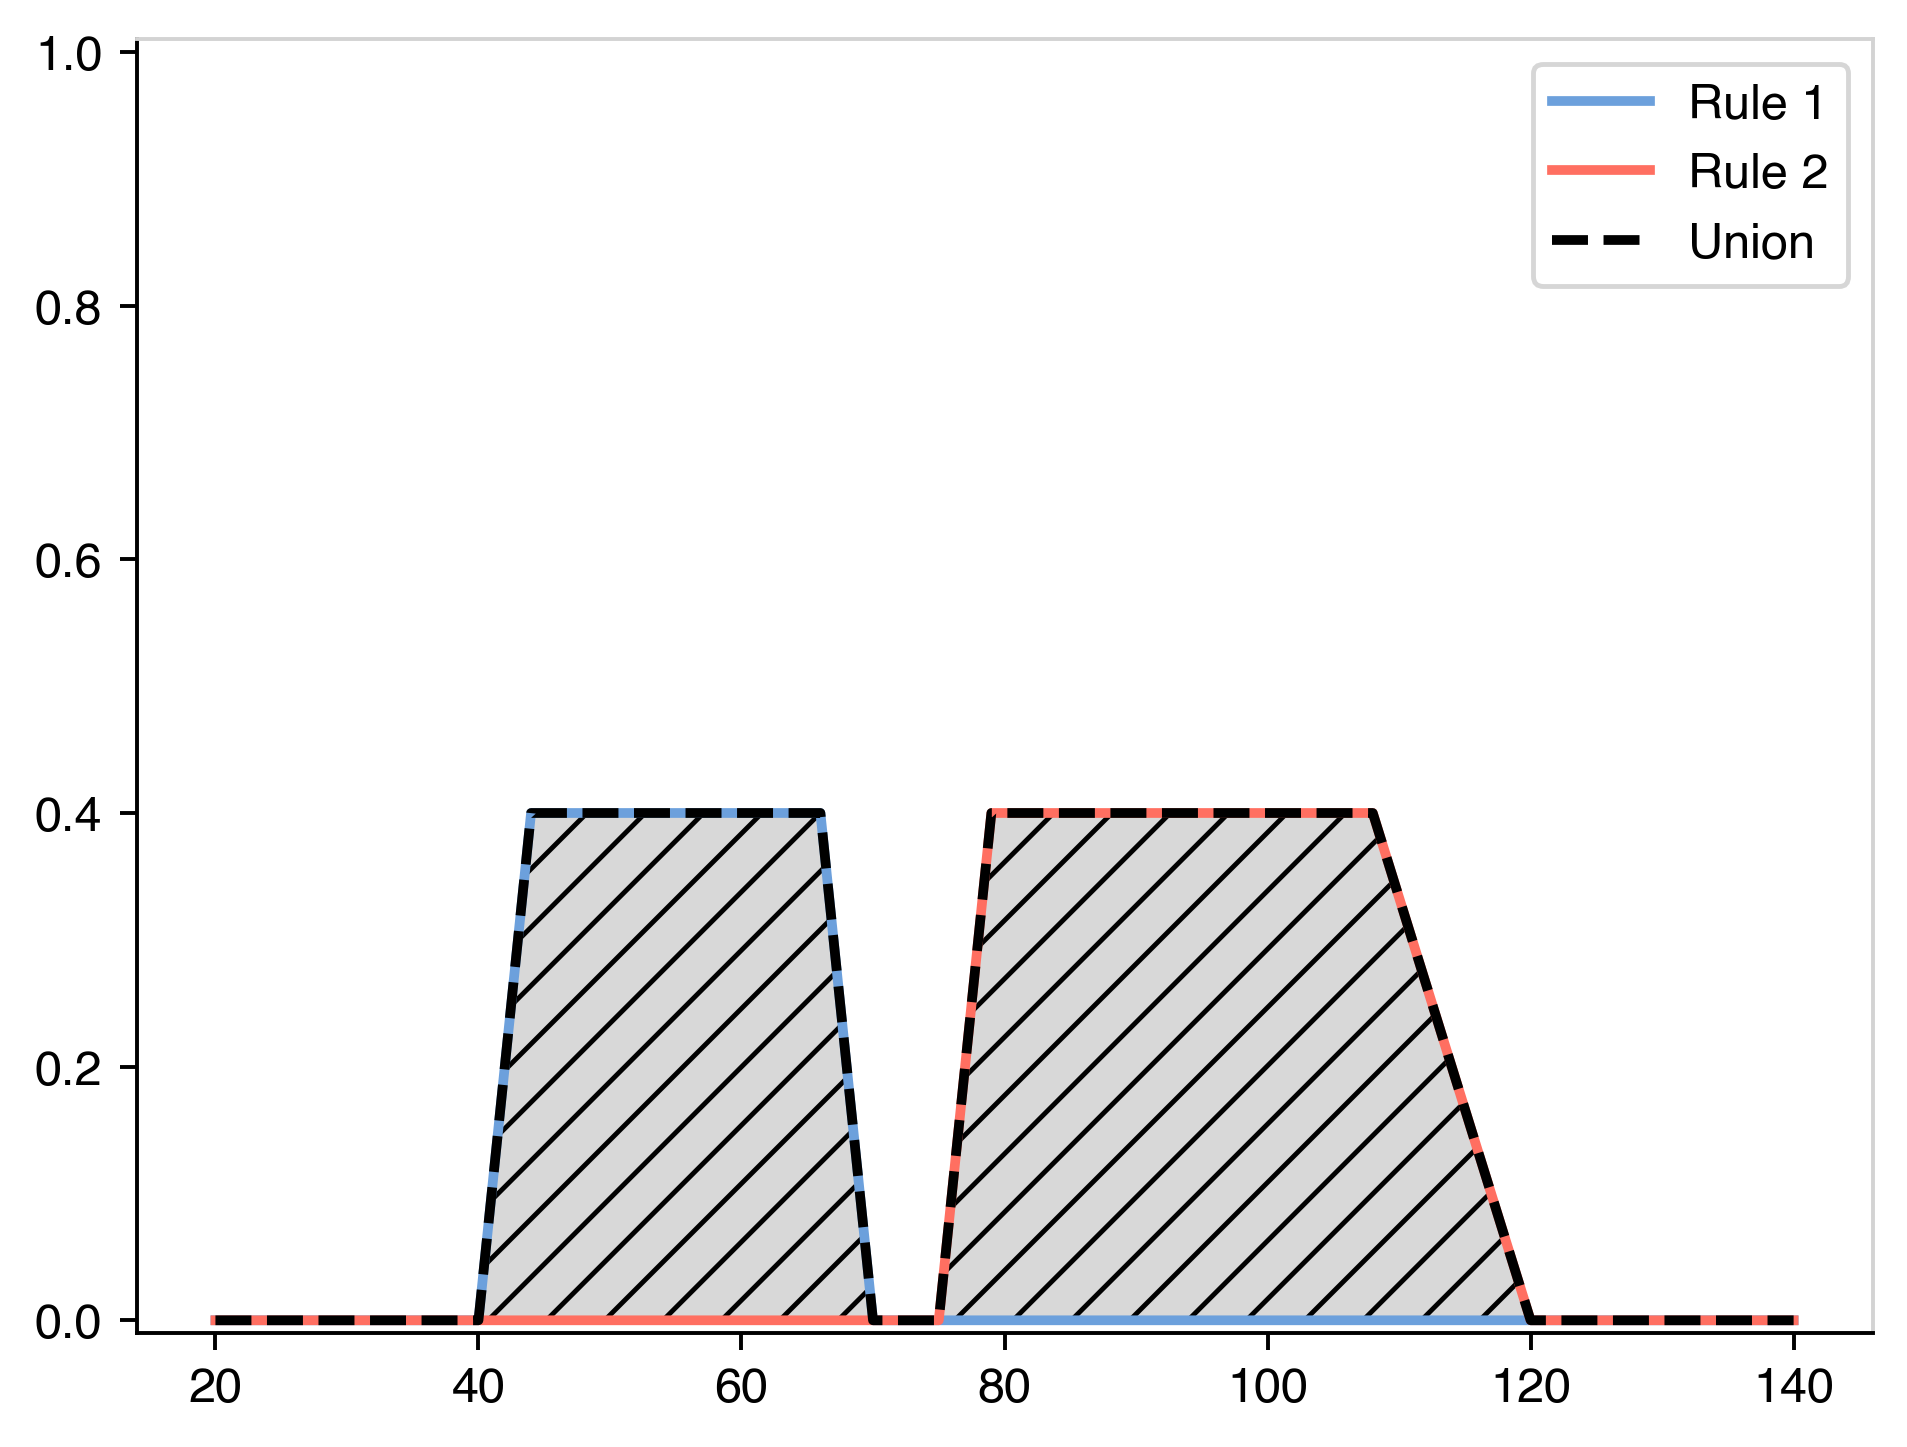

In [42]:


activation_mf_arrays = {
    "Rule 1": y1,
    "Rule 2": y2,
}

# Make these the same as the rule examples above depending on rule itself
plot_colors = {
    "Rule 1": ozone_cats["background"],
    "Rule 2": ozone_cats["extreme"],
}

fig, ax, y_agg = make_mf_figure(
    ozone_uod,
    activation_mf_arrays,
    plot_union=True,
    plot_colors=plot_colors,
    return_aggregated=True,
    # save_path=os.path.join(output_dir, "combined_activation_union.pdf")
)

fig.show()

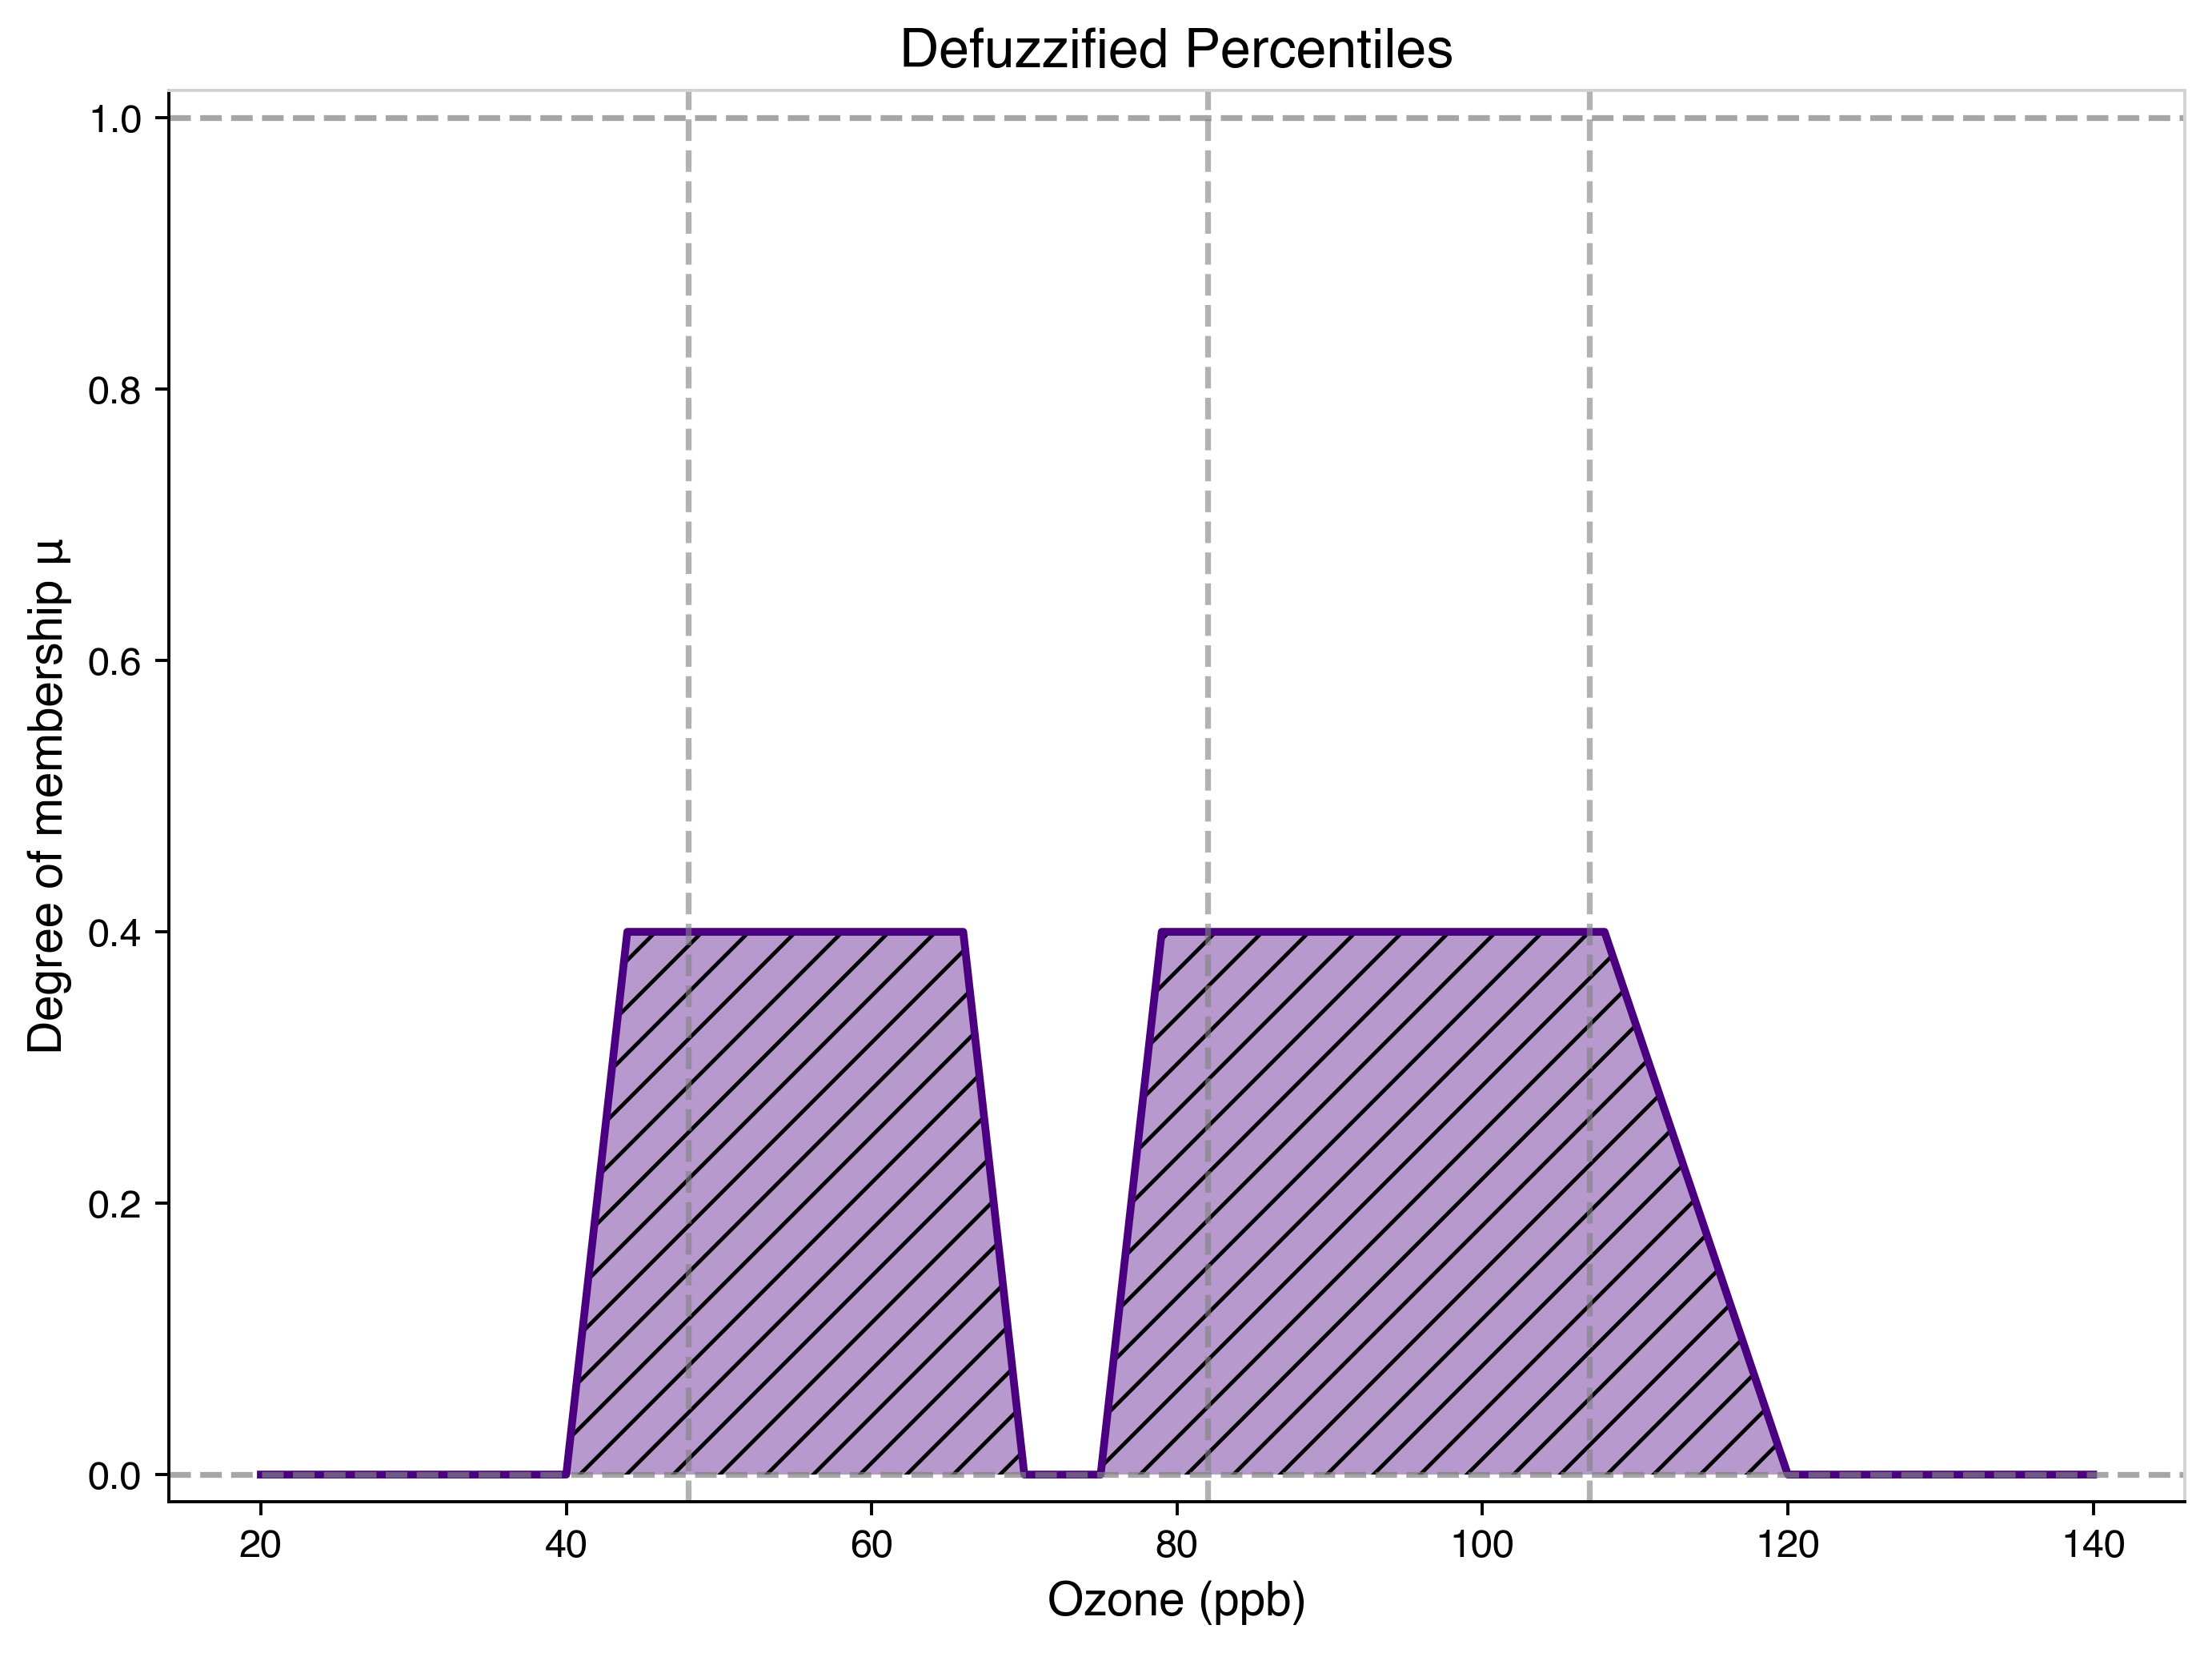

10th Percentile (Risk-Averse): 48
50th Percentile (Best Guess/Neutral): 82
90th Percentile (Risk-Tolerant): 107


In [43]:

# Defuzzify to obtain percentiles
percentiles = defuzzify_percentiles(
    ozone_uod,
    y_agg,
    percentiles=[10, 50, 90],
    do_plot=True,
    plot_fill=True,
    # save_path=os.path.join(output_dir, "defuzzified_percentiles.pdf")
)

print("10th Percentile (Risk-Averse):", percentiles[10])
print("50th Percentile (Best Guess/Neutral):", percentiles[50])
print("90th Percentile (Risk-Tolerant):", percentiles[90])

# Note this isn't so good for bimodal etc! two-scenario cluster

In [44]:
# How to implement that ready for operations?
# Seems the scikit-fuzz defuzzify methods don't do AUC percentiles

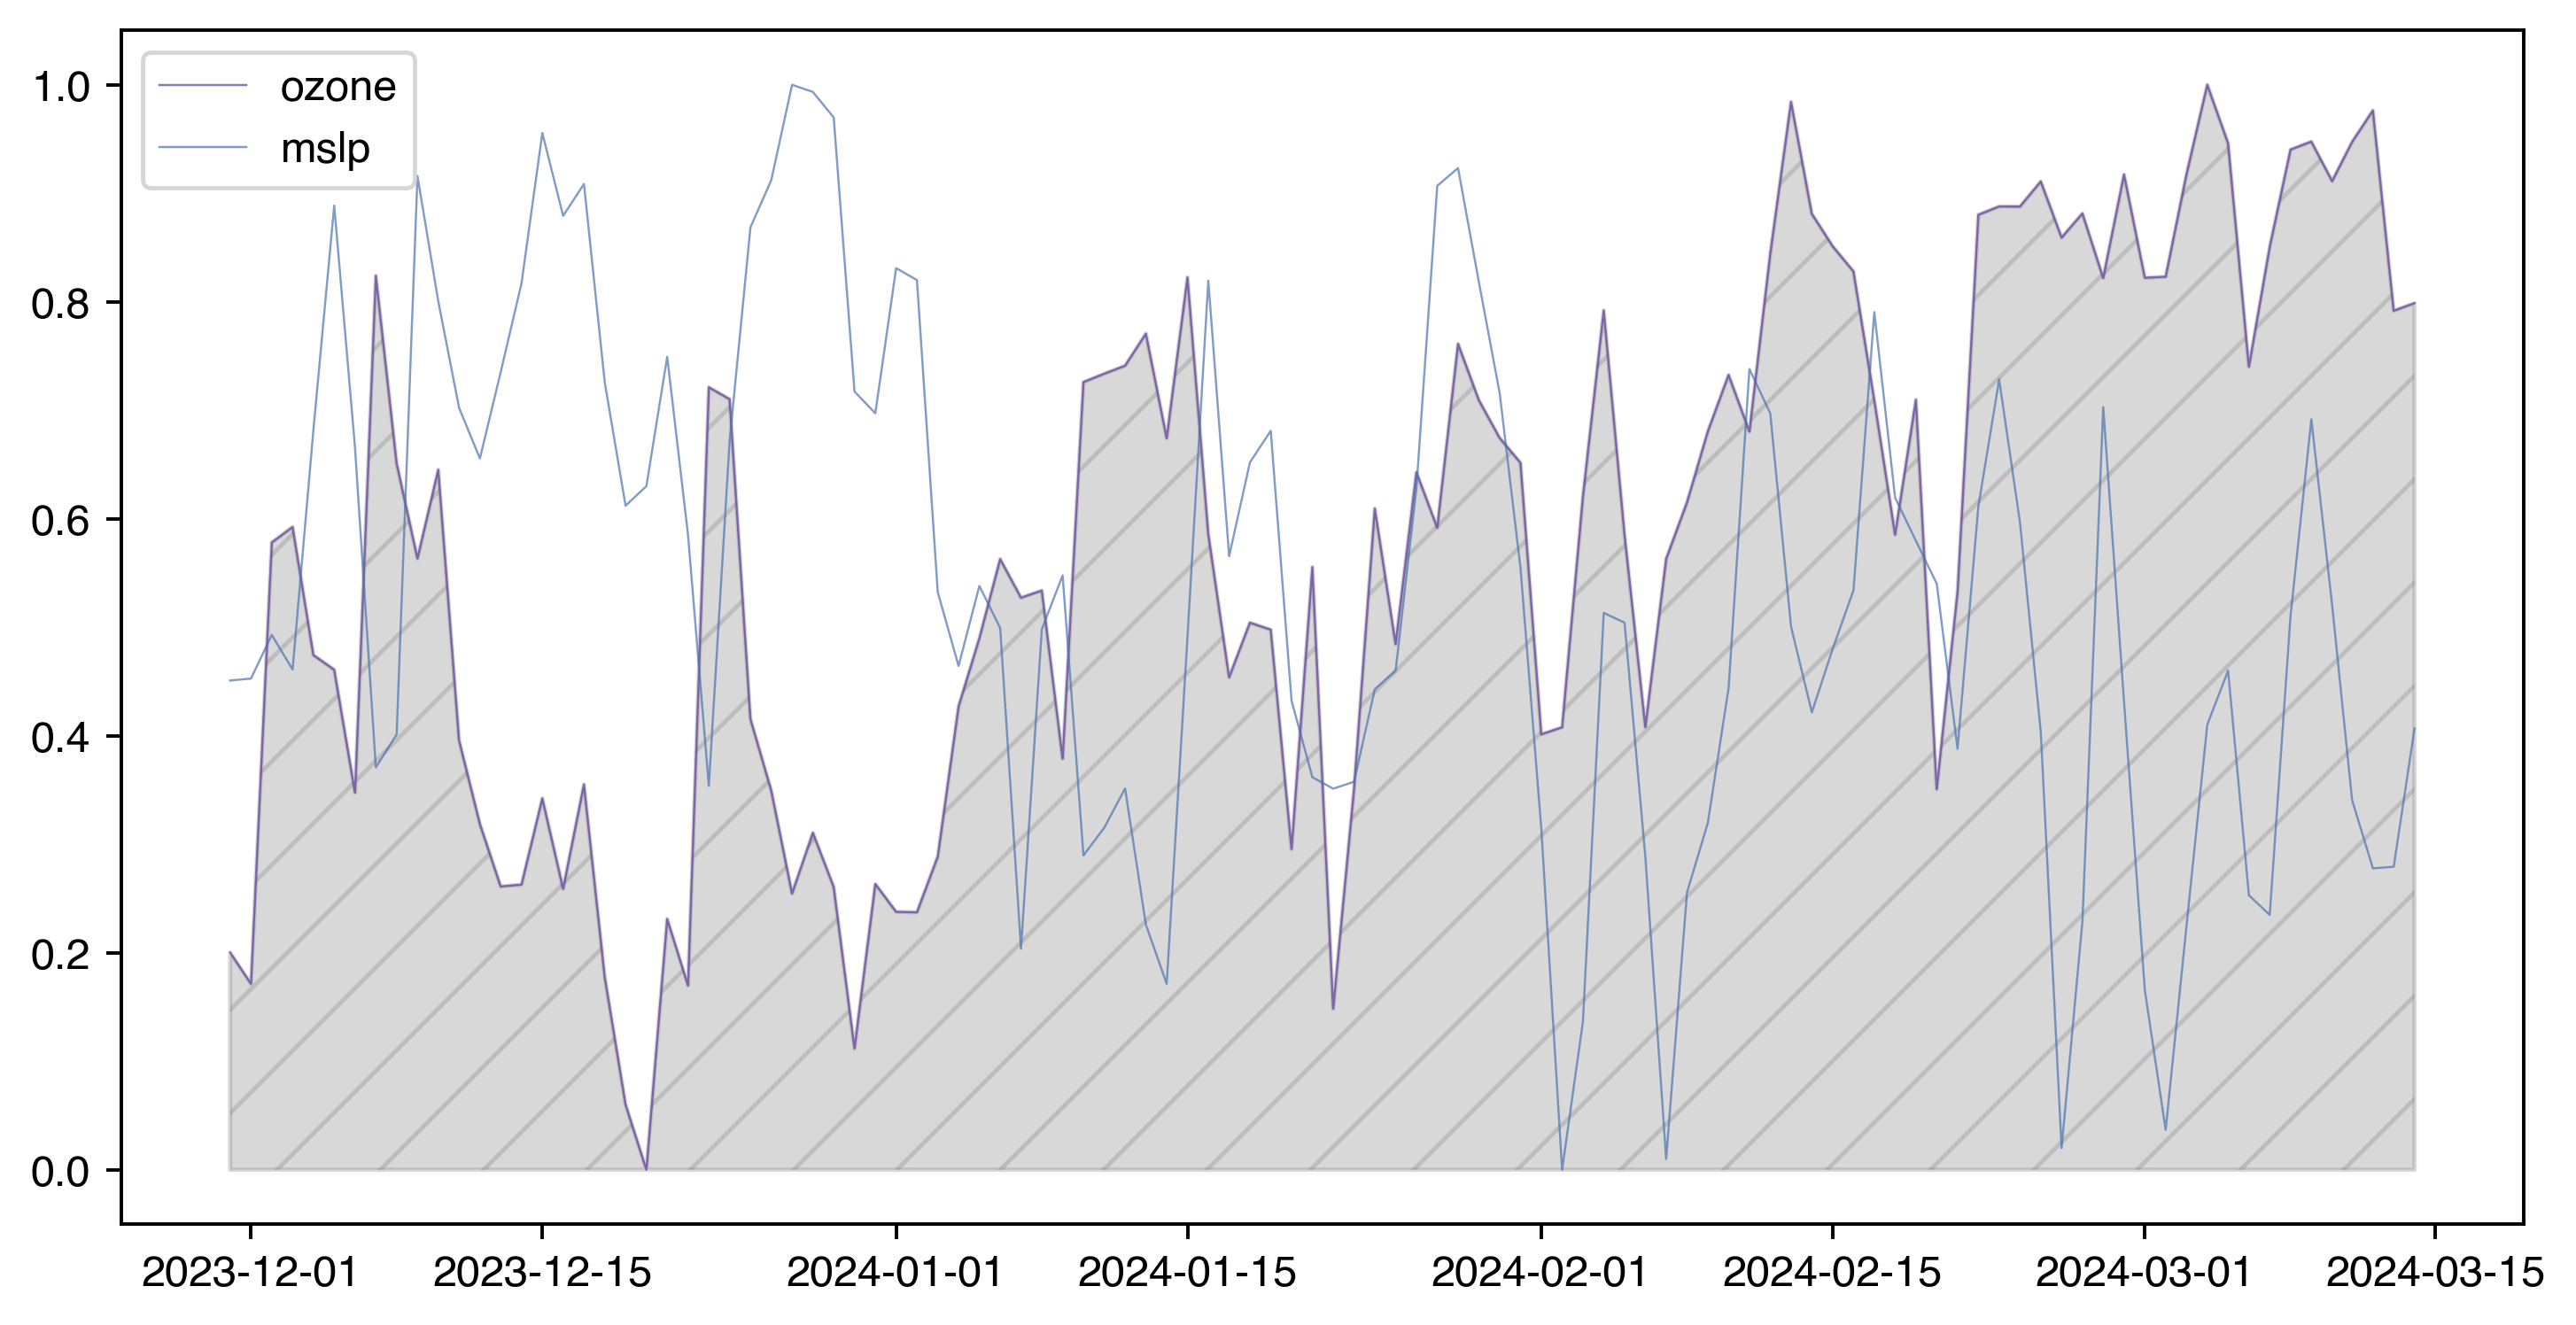

In [45]:

def normalize_and_plot(data_dict, labels, ax=None, colors=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if colors is None:
        colors = {
            "ozone": "#5D3A9B",
            "mslp": "#4C72B0",
            "wind": "#55A868",
            "snow": "#00BFFF",
            "solar": "#E17C05"
        }

    for label, data in zip(labels, data_dict.values()):
        if isinstance(data, pd.DataFrame):
            data = data.squeeze()  # Convert DataFrame to Series if necessary
        normalized_data = (data - data.min()) / (data.max() - data.min())
        ax.plot(data.index, normalized_data, label=label, lw=0.5, alpha=0.7, color=colors[label])
        if label == "ozone":
            ax.fill_between(data.index, normalized_data, alpha=0.3, hatch='/', color='gray')

    # For 2021/2022 case study
    annotate_dates = True
    if annotate_dates and (year == 2022):
        # Add thick black lines with solid arrows for specific dates
        dates = ['2022-02-27', '2022-01-02', '2021-12-14']
        date_labels = ['27 Feb', '2 Jan', '14 Dec']
        for date, label in zip(dates, date_labels):
            date_timestamp = pd.Timestamp(date)
            ax.annotate('', xy=(date_timestamp, 0.96), xytext=(date_timestamp, 0.96),
                        arrowprops=dict(facecolor='black', shrink=0.05, width=5, headwidth=10))
            ax.text(date_timestamp, 0.96, label, ha='center', fontsize=10)
            # Vertical grey lines for each date here
            ax.axvline(date_timestamp, color=colors['ozone'], linestyle='--', lw=0.5)

    # Overlap forecast - need to create that elsewhere and pass it in
    pass

    ax.legend()
    plt.show()
    return

# Example usage
data_dict = {
    "ozone": repr_ozone,
    "mslp": repr_mslp,
    # "wind": repr_wind,
    # "snow": repr_snow,
    # "solar": repr_solar
}
labels = data_dict.keys()
normalize_and_plot(data_dict, labels)

### Testing FIS with representative values
Now, after creating representative values for the five input and output variables, we can test the FIS to evaluate performance for this time period.


            possibility
background     0.381167
moderate       0.618833
elevated       0.000000
extreme        0.000000


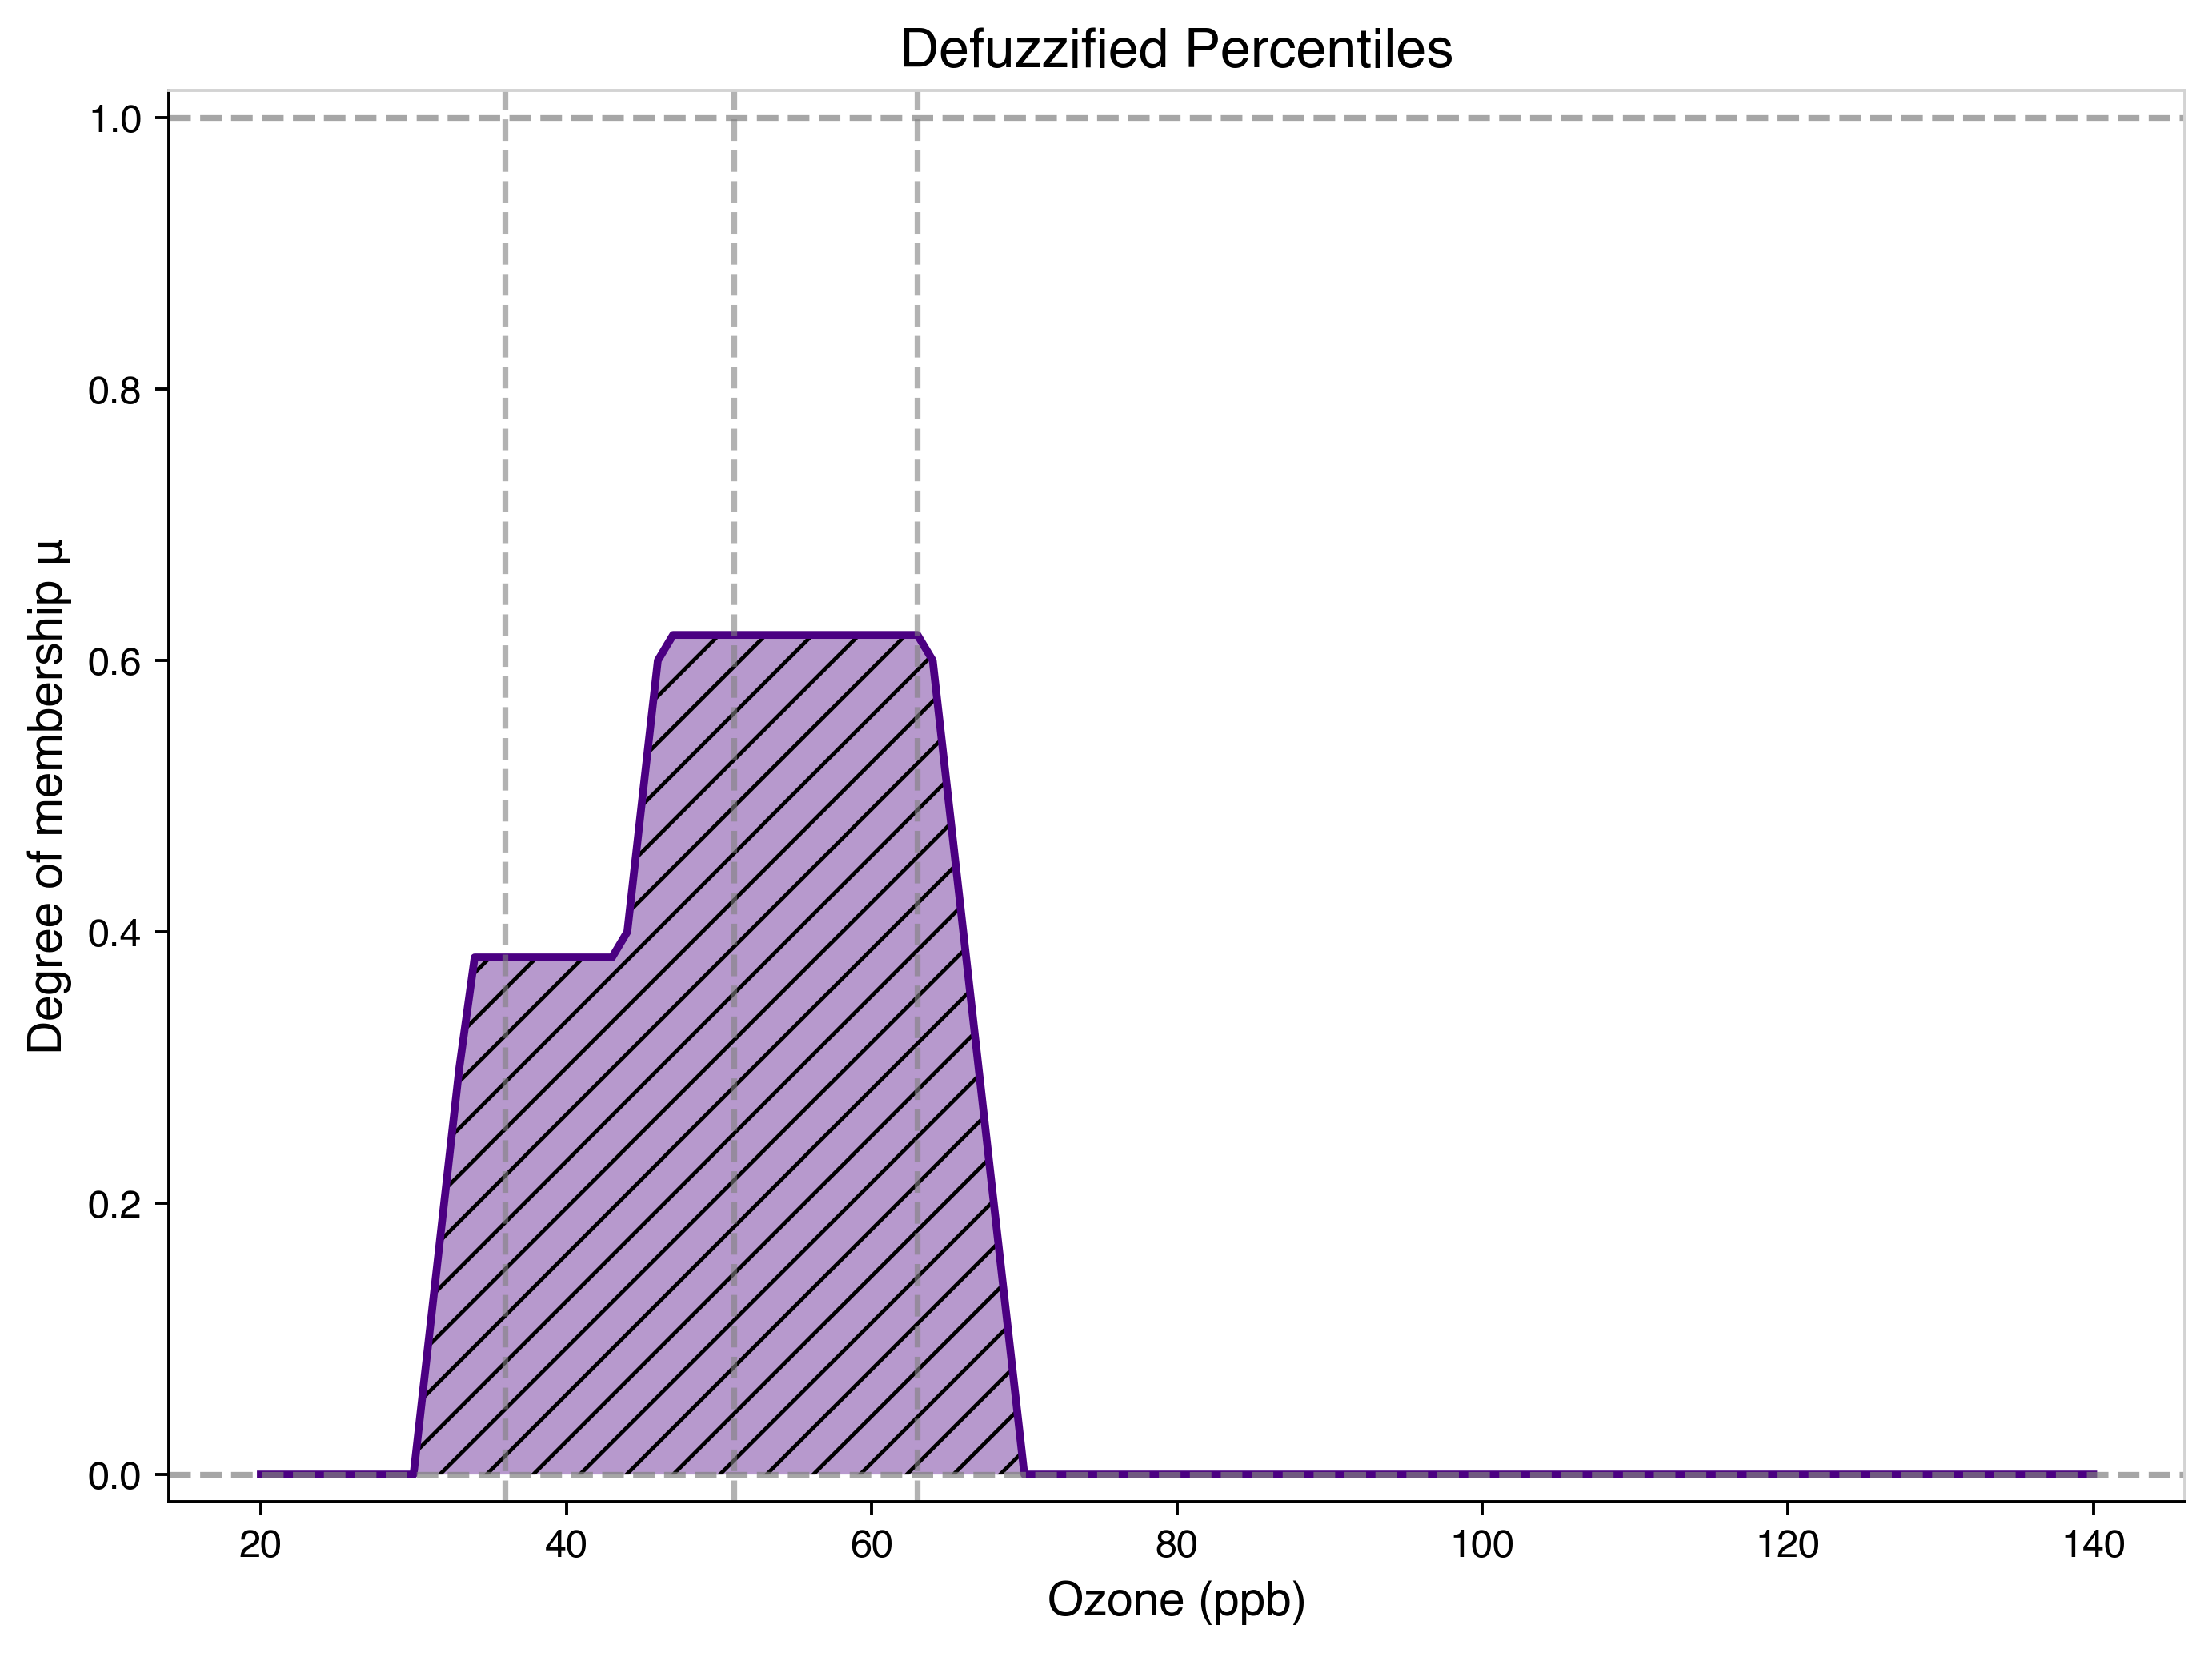

Percentiles:
  10th: 36.00 ppb
  50th: 51.00 ppb
  90th: 63.00 ppb


In [46]:
df_rep = pd.concat([repr_snow, repr_mslp, repr_wind, repr_solar, repr_ozone], axis=1)

done_plot = 0

for i, row in df_rep.iterrows():
    snow_v = row['snow_depth']
    mslp_v = row['sea_level_pressure']
    wind_v = row['wind_speed']
    solar_v = row['solar_radiation']

    ozone_simulation.input['snow'] = snow_v
    ozone_simulation.input['mslp'] = mslp_v
    ozone_simulation.input['wind'] = wind_v
    ozone_simulation.input['solar'] = solar_v

    ozone_simulation.compute()

    poss_df = create_possibility_df(ozone_simulation, ozone,
                                    ozone_cats.keys(), normalize=False)

    if (poss_df['possibility']['background'] < 0.9) and (done_plot < 1):
        print(poss_df)
        check_possibility_curve(poss_df, ozone)
        done_plot += 1

    # Generate the 10th, 50th, 90th percentile forecasts from the aggregated activation
    y_agg = compute_aggregated_distr(poss_df, ozone)
    pc_dict = defuzzify_percentiles(ozone.universe, y_agg,
                                        percentiles=[10, 50, 90])
    df_rep.at[i, 'ozone_10pc'] = pc_dict[10]
    df_rep.at[i, 'ozone_50pc'] = pc_dict[50]
    df_rep.at[i, 'ozone_90pc'] = pc_dict[90]

In [47]:
df_rep.head()

,snow_depth,sea_level_pressure,wind_speed,solar_radiation,ozone_concentration,ozone_10pc,ozone_50pc,ozone_90pc
date_time,,,,,,,,
2023-11-30 00:00:00-07:00,46.989999,101825.773438,1.54100,NaN,23.7224,36.0,44.0,53.0
2023-12-01 00:00:00-07:00,50.799999,101832.539062,1.67875,NaN,22.7523,36.0,44.0,53.0
2023-12-02 00:00:00-07:00,21.593810,101983.992188,2.52350,NaN,36.4946,36.0,44.0,53.0
2023-12-03 00:00:00-07:00,0.000000,101864.070312,3.01875,NaN,36.9777,36.0,44.0,53.0
2023-12-04 00:00:00-07:00,0.000000,102695.835938,2.66100,NaN,32.9879,36.0,44.0,53.0


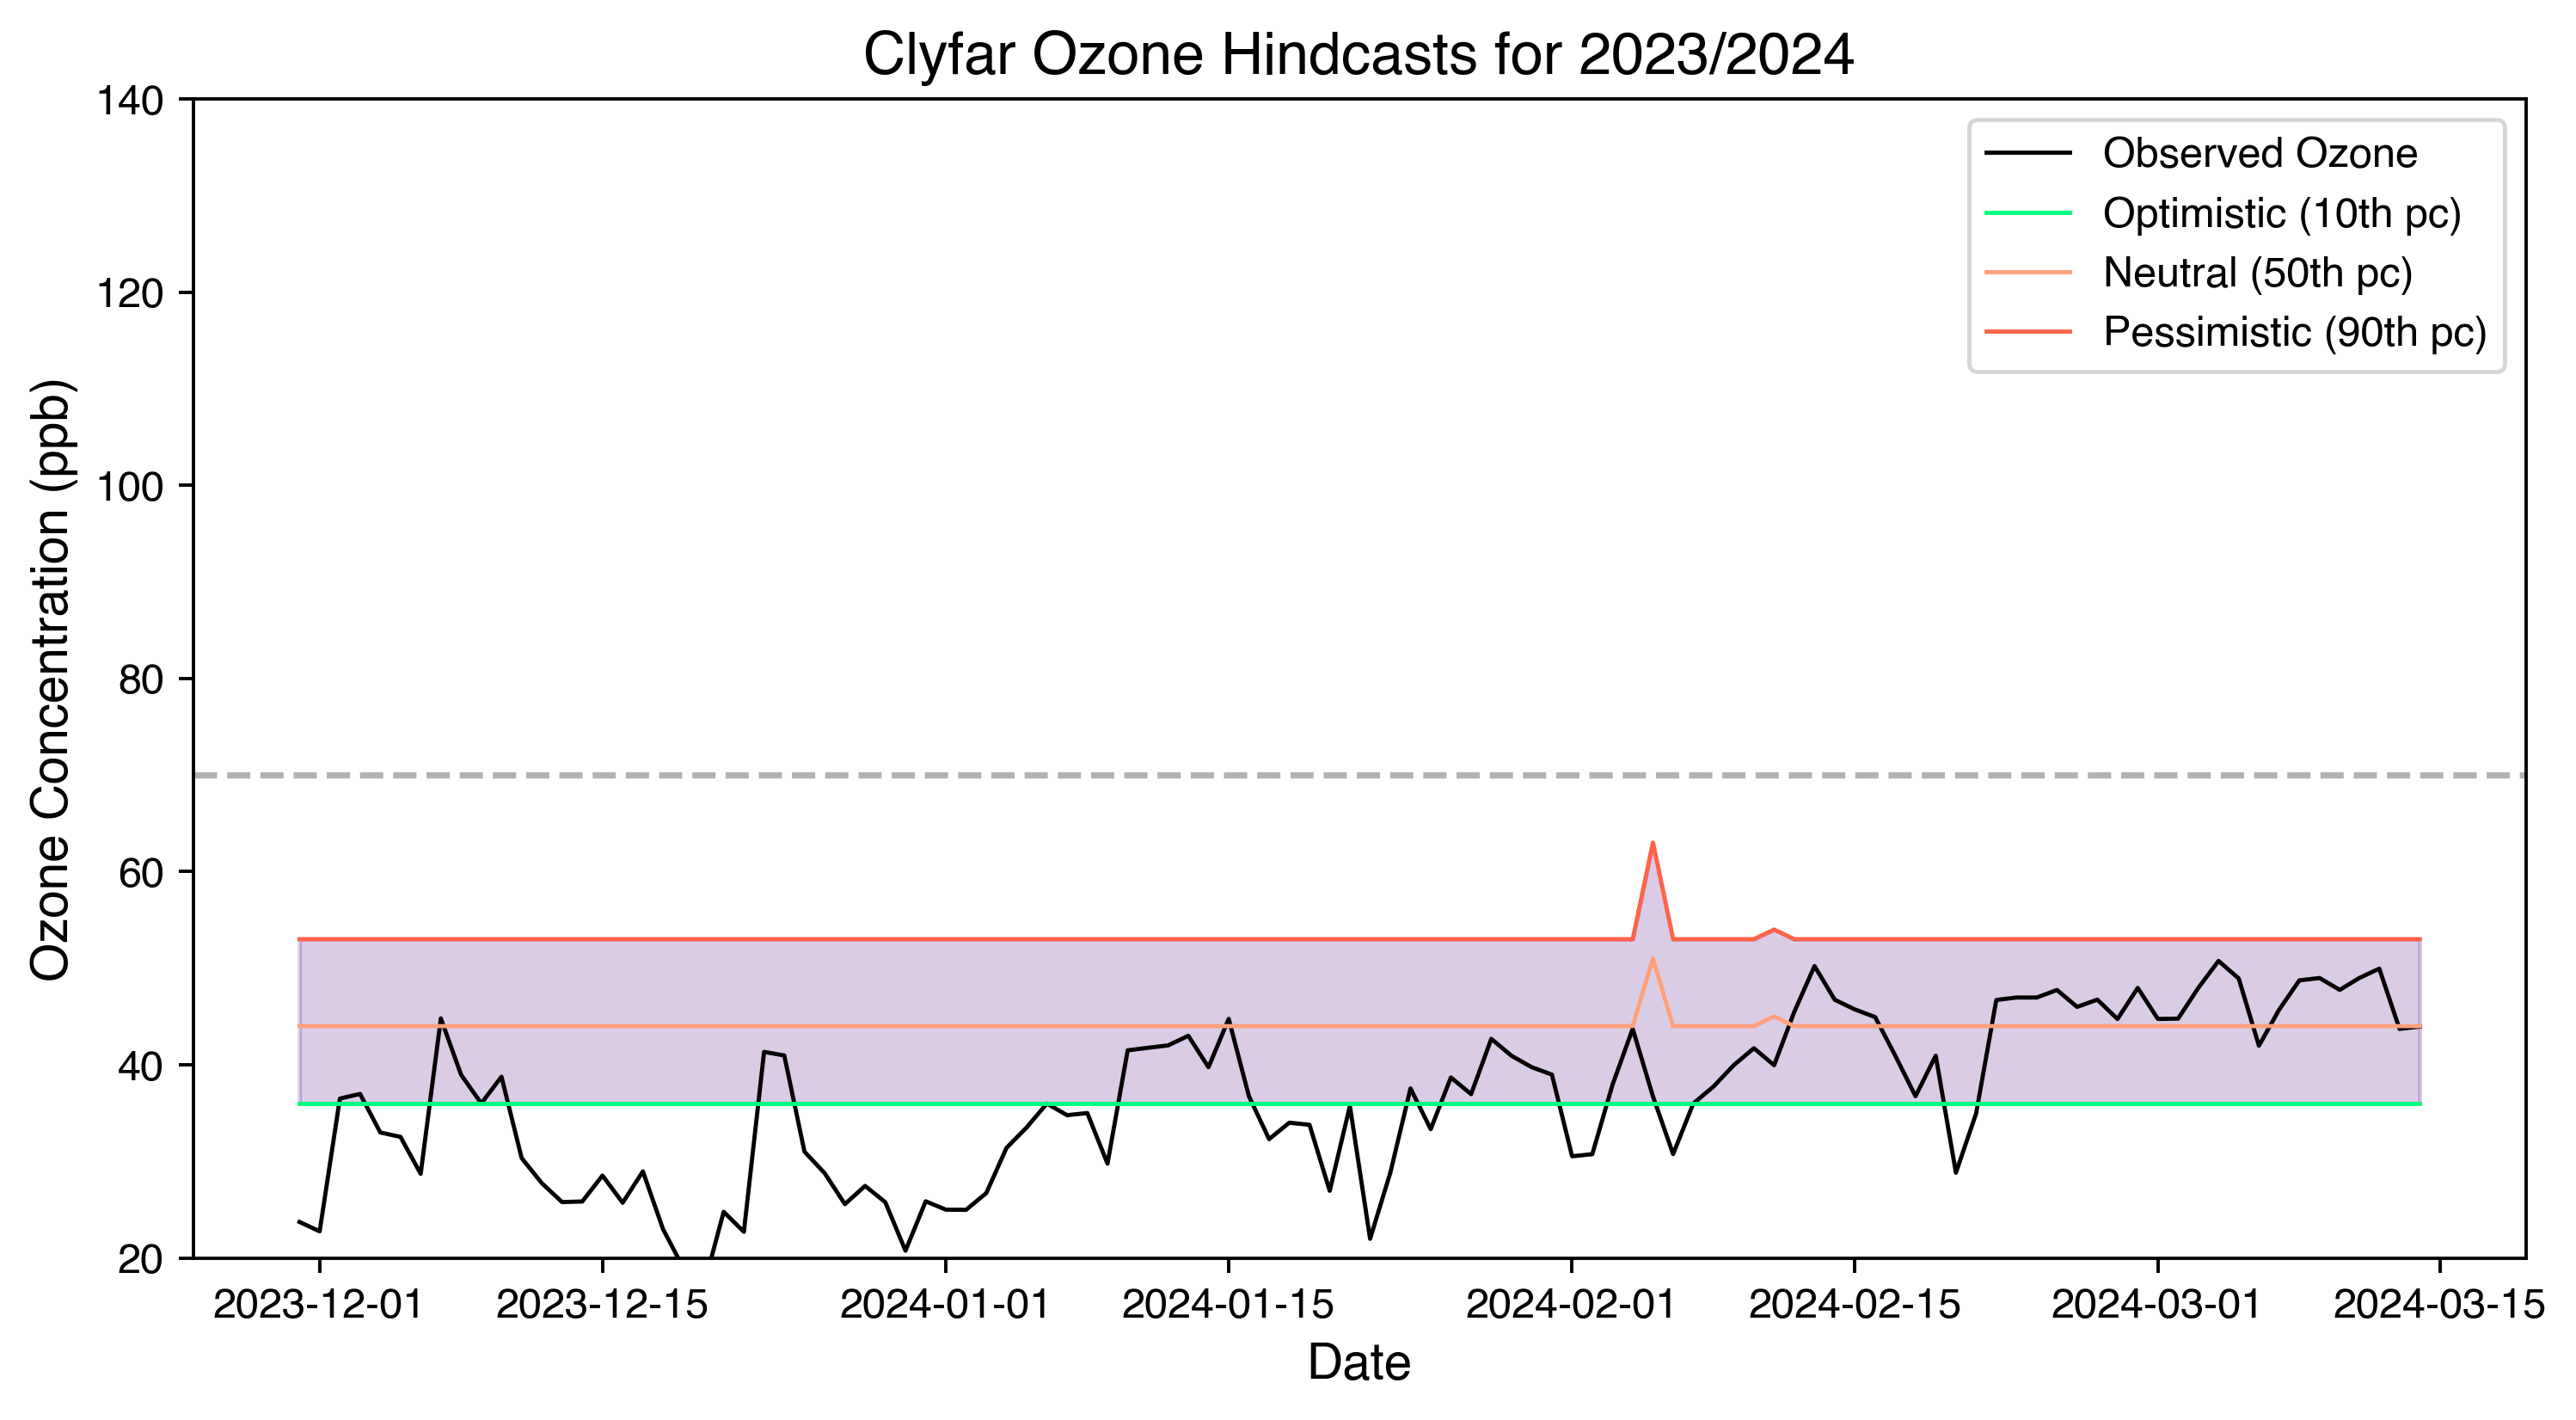

In [48]:
# Plot forecast and observed representative ozone values
fig,ax = plt.subplots(figsize=(10, 5))

# This is truth
ax.plot(df_rep.index, df_rep['ozone_concentration'], label="Observed Ozone",
            color='black', lw=1)

# Plot best-, average-, and worst-case scenarios (10th, 50th, 90th percentiles)
# Use plot colours defined in pc_colors
ax.plot(df_rep.index, df_rep['ozone_10pc'], label="Optimistic (10th pc)",
            color=pc_colors[10], lw=1)
ax.plot(df_rep.index, df_rep['ozone_50pc'], label="Neutral (50th pc)",
            color=pc_colors[50], lw=1)
ax.plot(df_rep.index, df_rep['ozone_90pc'], label="Pessimistic (90th pc)",
            color=pc_colors[90], lw=1)

# Shade between the 10th and 90th with a very faint fave_color
ax.fill_between(df_rep.index, df_rep['ozone_10pc'], df_rep['ozone_90pc'],
                color=fave_color, alpha=0.2)

# Label this is Clyfar ozone hindcasts for 2021/2022, perfect inputs (obs)
# x-axis is date, y-axis is ozone concentration (ppb)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Ozone Concentration (ppb)", fontsize=12)
ax.set_title(f"Clyfar Ozone Hindcasts for {year-1}/{year}", fontsize=14)
ax.set_ylim(ozone_uod[0], ozone_uod[-1])

# Mark horizontal line at 70 ppb as grey dashed line in background (low z order)
ax.axhline(y=70, color='grey', linestyle='--', alpha=0.6, zorder=0)

ax.legend()
plt.show()
